In [1]:
from svae import SpikeSlabVAE, metrics, sparse_shift, sVAE
import fsspec
import scvi
import scanpy as sc
import h5py
import numpy as np
import networkx
import desc 
import matplotlib
import matplotlib.pyplot as plt
import umap
import scvelo as scv
import pandas as pd
import igraph
import networkx
import anndata as AnnData
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np
import svae
import os
import cellrank as cr
import seaborn as sns
import os
import scrublet as scr
from scipy.stats import chi2_contingency
%load_ext rpy2.ipython
%matplotlib inline 
sc.settings.verbosity = 3     
sc.set_figure_params(figsize=(4, 4))
np.random.seed(42)

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument i

# Reading in OS384 perturb-seq data

In [2]:

# Reading in the macthed cell barcodes and guides that were generated in wynton
guide_cell_barcodes = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_guide_cell_barcode_matches_counts.txt', delimiter='\t', index_col=0, header=None) 


# Adding the '-1' string to the guide cell barcodes read in
guide_cell_barcodes.index = [str(idx) + '-1' for idx in guide_cell_barcodes.index]

# Shifting the index to an actual column
guide_cell_barcodes = guide_cell_barcodes.reset_index()


# Renaming the column names
guide_cell_barcodes = guide_cell_barcodes.rename(columns={guide_cell_barcodes.columns[0]: 'cell_barcode', 
                                                          guide_cell_barcodes.columns[1]: 'guide',
                                                          guide_cell_barcodes.columns[2]: 'count'})

# Keeping the cell_barcode/guide pair that has the highest count to move forward with the rest of the analysis
result_df = guide_cell_barcodes.loc[guide_cell_barcodes.groupby('cell_barcode')['count'].idxmax()].reset_index(drop=True)


# Creating a new column in the adata.obs object for the actual cell barcode
adata.obs = adata.obs.assign(cell_barcode=adata.obs.index)



# Creating a dataframe for the adata.obs object
adata_obs_df = adata.obs

In [10]:
# Perform an inner join on the 'cell_barcode' column
matched_df = adata_obs_df.merge(result_df, on='cell_barcode', how='inner')

# Now matched_df contains only the rows where the cell_barcode values matched in both DataFrames


In [13]:
matched_df_unique = matched_df.drop_duplicates(subset=['cell_barcode'], keep='first')

print(matched_df_unique)

           cell_barcode                 guide  count
0    AAAGTGACAAGATGTA-1  GGGATCGGGAGAAGCGAAGA     14
1    AAAGTGAGTAGATGTA-1  GGCTCCGGGTGGCCTCGGTT     67
2    AAATGGAAGACCTTAT-1  GTGTGGCTGAAGCAGCGAGG   2020
3    AAATGGACAATAATGG-1  GGCTCCGGGTGGCCTCGGTT   8423
4    AAATGGACACGTTGCG-1  GGGATCGGGAGAAGCGAAGA   4206
..                  ...                   ...    ...
310  TTGTTTGGTGAGATGC-1  GGCGGGGAGGCAGCAGGCGC     27
311  TTTACTGAGCCAAGCA-1  GGGATCGGGAGAAGCGAAGA      9
312  TTTACTGCAAGTGATA-1  GGCGGGGAGGCAGCAGGCGC   7996
313  TTTCATGTCCCAAGTG-1  GGCGGGGAGGCAGCAGGCGC  27893
314  TTTGGTTAGTGTCCGT-1  GGCGGGGAGGCAGCAGGCGC     19

[315 rows x 3 columns]


In [14]:
# Reading in the guide key
Gene_guide_key = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/Perturb_osteo_whitelist_guides .csv')

Gene_guide_key = Gene_guide_key.iloc[:, [1, 2]]

# Rename the columns
Gene_guide_key.columns = ['guide', 'Gene']

In [15]:
matched_df_unique = matched_df_unique.merge(Gene_guide_key, on='guide', how='left')

# Dropping the guide column
matched_df_unique = matched_df_unique.drop('guide', axis=1)


matched_df_unique = matched_df_unique.drop('count', axis=1)

In [16]:

matched_df_unique = matched_df_unique.drop_duplicates()

In [17]:
matched_df_unique = matched_df_unique.set_index('cell_barcode')

In [19]:
for barcode in matched_df_unique.index:
    if barcode in adata.obs.index:
        # If barcode exists in AnnData, add/update gene info in .obs
        # Example: Add a concatenated string of genes to a new column, handling duplicates
        genes = matched_df_unique.loc[barcode, 'Gene']
        gene_str = ', '.join(genes) if isinstance(genes, pd.Series) else genes
        adata.obs.at[barcode, 'Gene'] = gene_str
    else:
        # If barcode does not exist, add a new entry (optional, depends on your analysis needs)
        # You might need to handle adding new cells to `.X` or other attributes depending on your data structure
        genes = 'control'

In [20]:
adata.obs['Gene'] = adata.obs['Gene'].fillna('control')

In [22]:
adata.obs.iloc[:, 1].unique()

array(['control', 'NFE2L3', 'IRF1', 'JUN', 'NR0B1', 'TCF4', 'STAT1',
       'NFKB2', 'KLF12', 'ZNF22', 'JUNB', 'FOS'], dtype=object)

In [25]:
adata.var_names_make_unique()

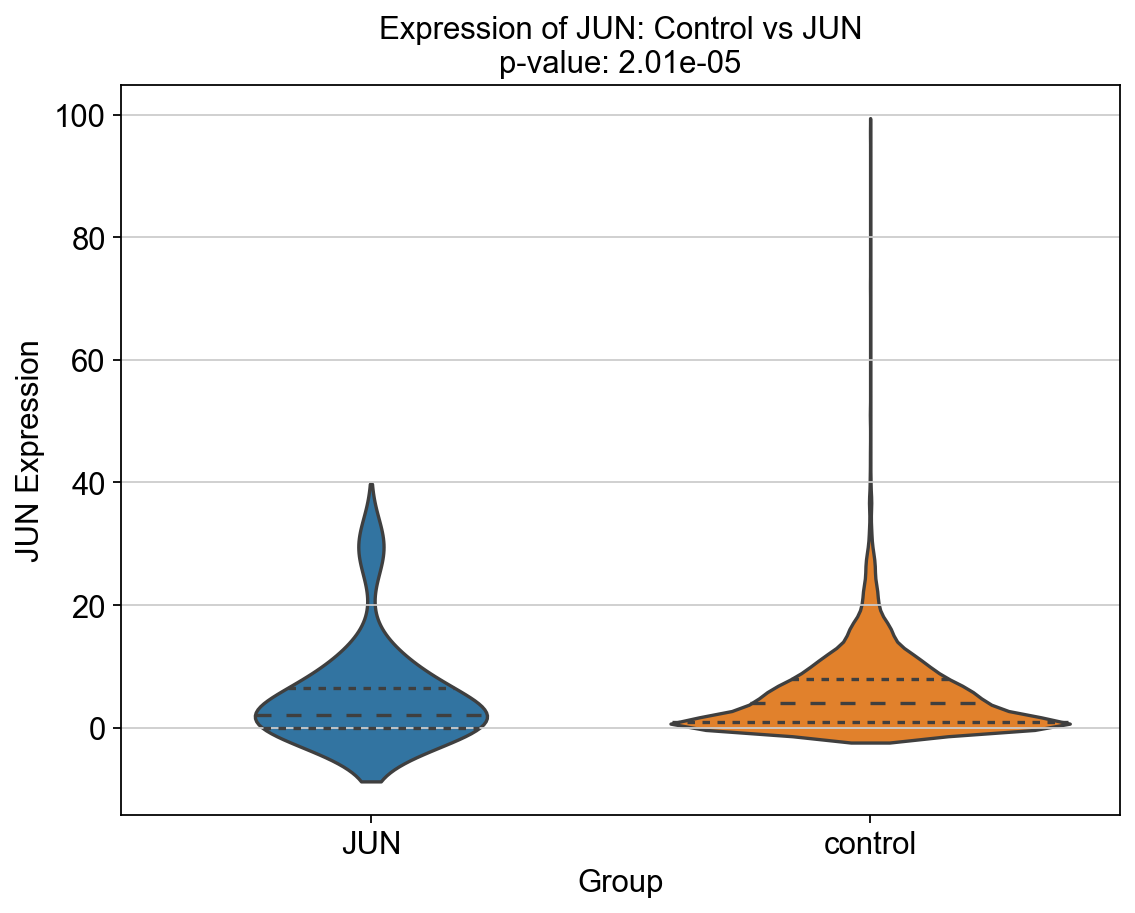

In [30]:

# Assuming 'adata' is your Anndata object

# Filter the Anndata object to include only 'control' and 'JUN' cells
adata_filtered = adata[adata.obs['Gene'].isin(['control', 'JUN'])]

# Calculate the expression of 'JUN' gene
jun_expression = adata_filtered[:, adata_filtered.var_names == 'JUN'].X

# Convert the sparse matrix to a dense array if necessary
if isinstance(jun_expression, np.ndarray):
    dense_jun_expression = jun_expression
else:
    dense_jun_expression = jun_expression.toarray()

# Split the expression data into 'control' and 'JUN' groups based on the 'Gene' category
control_expression = dense_jun_expression[adata_filtered.obs['Gene'] == 'control'].flatten()
jun_expression = dense_jun_expression[adata_filtered.obs['Gene'] == 'JUN'].flatten()

# Perform a t-test between the two groups
t_stat, p_value = ttest_ind(control_expression, jun_expression, equal_var=False)  # Assuming unequal variance

# Plotting the expression levels of 'JUN' for 'control' vs 'JUN' groups
plt.figure(figsize=(8, 6))
sns.violinplot(x=adata_filtered.obs['Gene'], y=np.concatenate([control_expression, jun_expression]), inner="quartile")
plt.title(f"Expression of JUN: Control vs JUN\np-value: {p_value:.2e}")
plt.ylabel('JUN Expression')
plt.xlabel('Group')

plt.show()


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


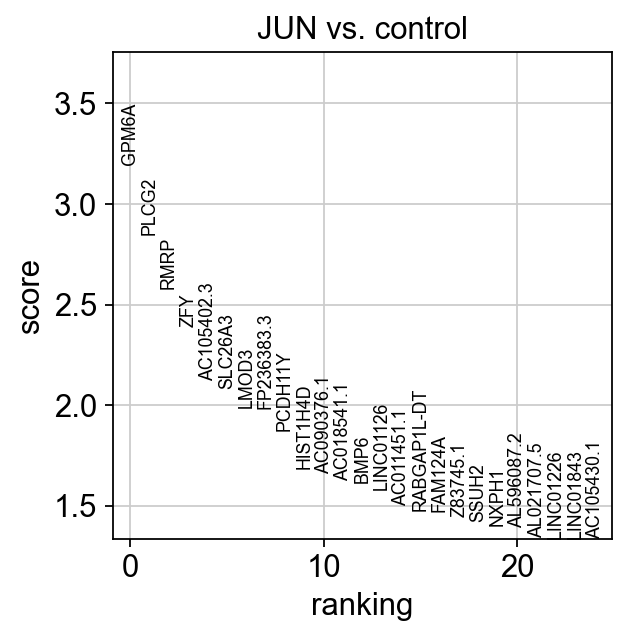

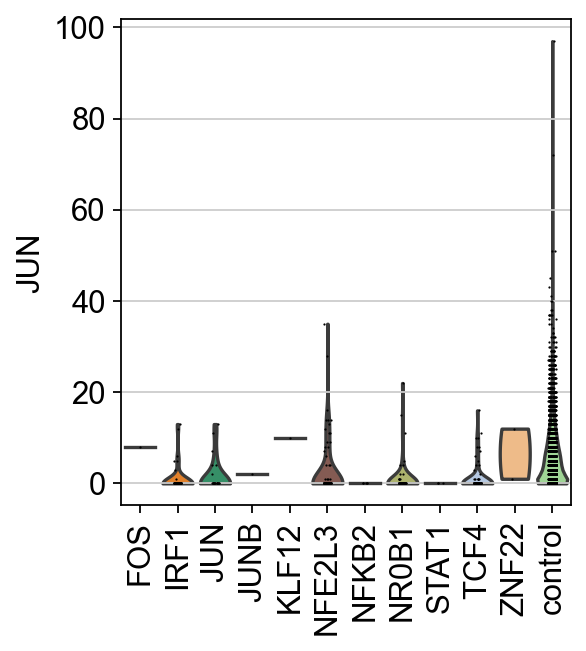

In [26]:
import scanpy as sc

# Assuming 'adata' is your Anndata object

# Set the 'Gene' column as the cell grouping for differential expression analysis
adata.obs['groups'] = adata.obs['Gene']

# Run differential expression analysis
# Comparing 'JUN' labeled cells vs 'control'
sc.tl.rank_genes_groups(adata, groupby='groups', groups=['JUN'], reference='control')

# Plotting the differential expression results
sc.pl.rank_genes_groups(adata, groups=['JUN'], n_genes=25, sharey=False)

# To specifically look at the 'JUN' gene expression comparison, you can extract the p-value, fold change, etc., from the result
de_result = adata.uns['rank_genes_groups']
gene_names = de_result['names']['JUN']
p_values = de_result['pvals']['JUN']
logfoldchanges = de_result['logfoldchanges']['JUN']

# If you specifically want to visualize 'JUN' expression, you can use the following:
# Note: This step assumes 'JUN' is significantly differentially expressed and you want to visualize it
if 'JUN' in gene_names:
    sc.pl.violin(adata, keys='JUN', groupby='groups', rotation=90)


# Filtering data based on QC parameters

reading /Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/filtered_feature_bc_matrix.h5
 (0:00:01)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


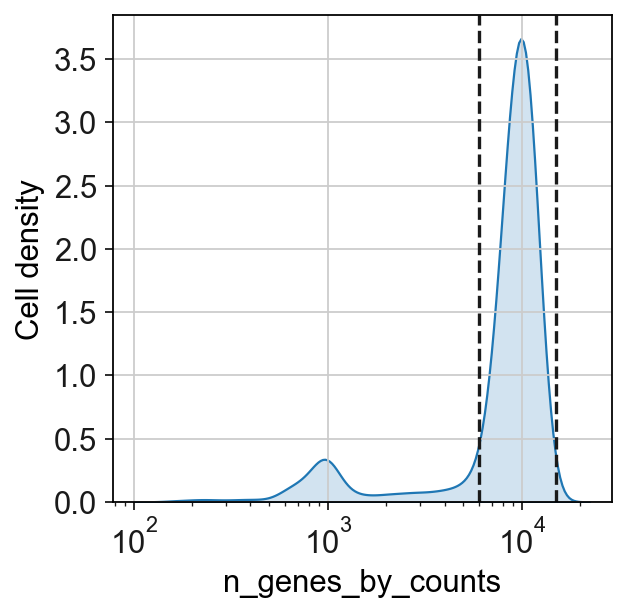

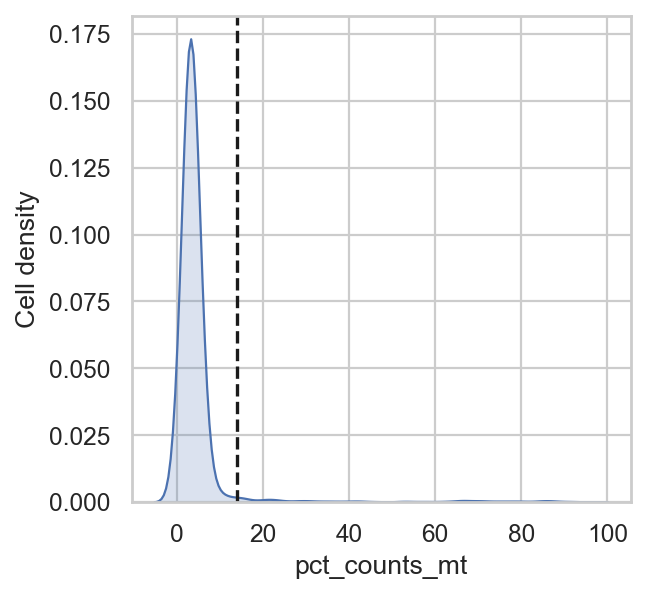

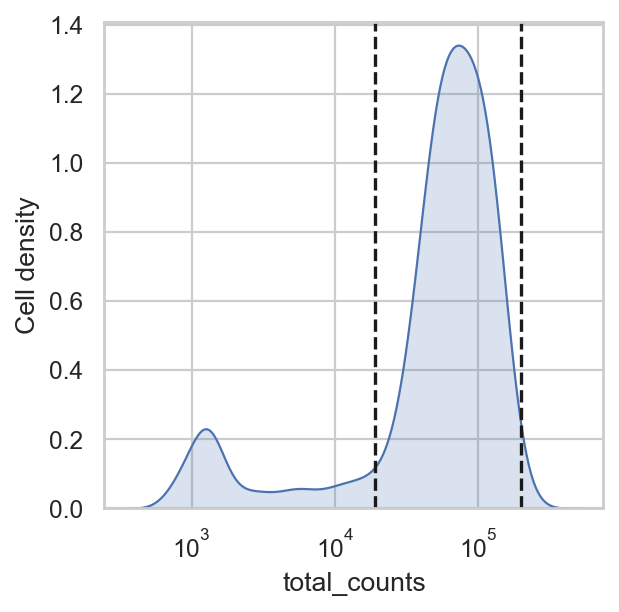

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:650: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_count_corr"] = np.round(


Normalized count data: X.
Extracted 1500 highly variable genes.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
97
35
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    128 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    191 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [2]:
adata = sc.read_10x_h5('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/filtered_feature_bc_matrix.h5')


# Making the var names unique
adata.var_names_make_unique()

# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

plt.figure()
sns.kdeplot(data=adata.obs, x='n_genes_by_counts', fill=True, alpha=0.2, log_scale=True)


# Add a vertical line at x = 20000
plt.axvline(x=15000, color='k', linestyle='--')
plt.axvline(x=6000, color='k', linestyle='--')


# Set labels and a classic theme
plt.xlabel("n_genes_by_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()


## Percent mitochondrial reads

#This may only show up correctly after filtering
plt.figure()
sns.kdeplot(data=adata.obs, x='pct_counts_mt', fill=True, alpha=0.2)

# Add a vertical line at x = 20000
plt.axvline(x=14, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("pct_counts_mt")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()

plt.figure()
sns.kdeplot(data=adata.obs, x='total_counts', fill=True, alpha=0.2, log_scale=True)

# Add a vertical line at x = 20000
plt.axvline(x=19000, color='k', linestyle='--')
plt.axvline(x=200000, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("total_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()


# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 19000) &
                        (adata.obs['total_counts'] <= 200000) &
                        (adata.obs['n_genes_by_counts'] >= 6000) &
                        (adata.obs['n_genes_by_counts'] < 15000) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 14)
                        ]

# weren't the samples filtered in seurat? check which additional cells and genes are filtered out here
#scv.pp.filter_genes(adata, min_shared_counts=20)


# normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=1500)


# make sure that the log transformation is where it belongs in this preprocessing sequence
scv.pp.log1p(adata)

# making the adata copy below might have to go before the log transformation

# preserving the counts
adata.layers["counts"] = adata.X.copy() 



# freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)

genes = adata.var.index.values

# reading in cell cycle genes in case I want to regress on that
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']

In [3]:
adata

AnnData object with n_obs × n_vars = 3816 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'initial_size', 'S_score', 'G2M_score', 'phase', 'ccdifference'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'hvg'
    layers: 'counts'

# Normalization and Dim Reduction

In [4]:
# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


    finished (0:00:05)


In [7]:
adata_plain = sc.read('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_adata_plain.h5ad')

In [8]:
adata_plain

AnnData object with n_obs × n_vars = 3244 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'S_score', 'G2M_score', 'phase', 'ccdifference', 'leiden'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [10]:
adata = AnnData.concat([adata, adata_plain], axis=0)
adata

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


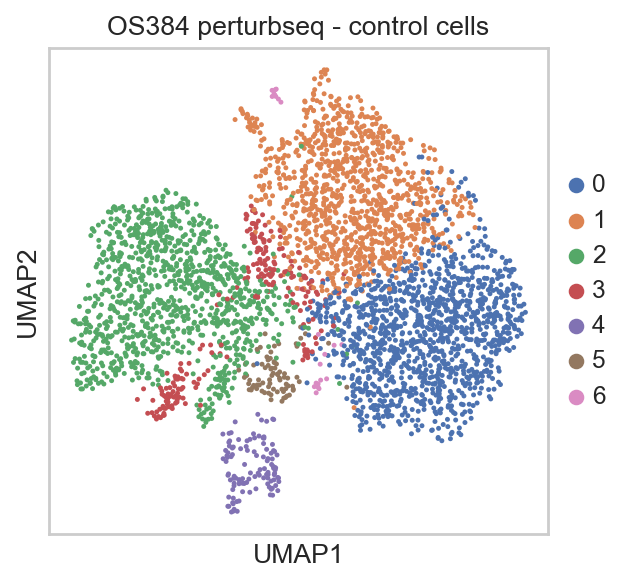

In [5]:

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

sc.tl.leiden(adata, resolution = 0.3)


sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS384 perturbseq",
    size = 20
)

# Filtering for contorl cells after normalization

In [6]:
adata_control = adata[adata.obs['Gene'] == 'control'].copy()

adata_control

adata_perturbed = adata[adata.obs['Gene'] != 'control'].copy()

KeyError: 'Gene'

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

sc.tl.leiden(adata, resolution = 0.3)


sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS384 perturbseq",
    size = 20
)

# Chisquared analysis

In [ ]:
adata = filtered_adata

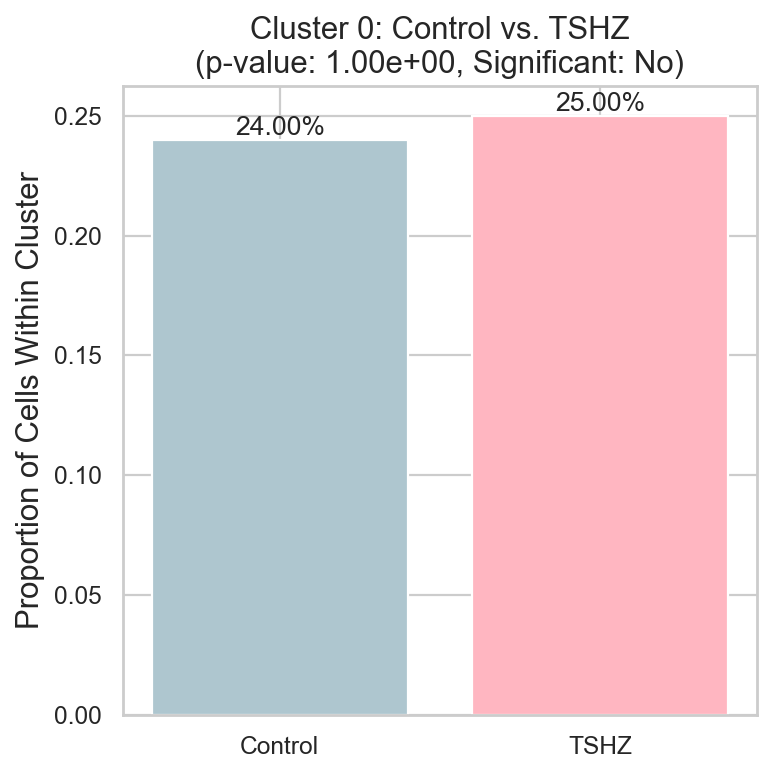

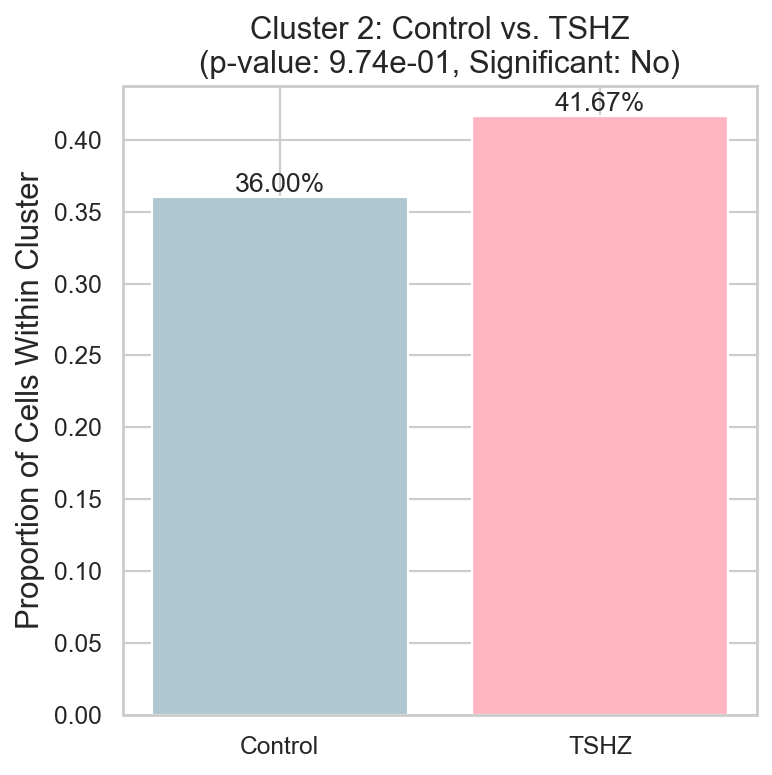

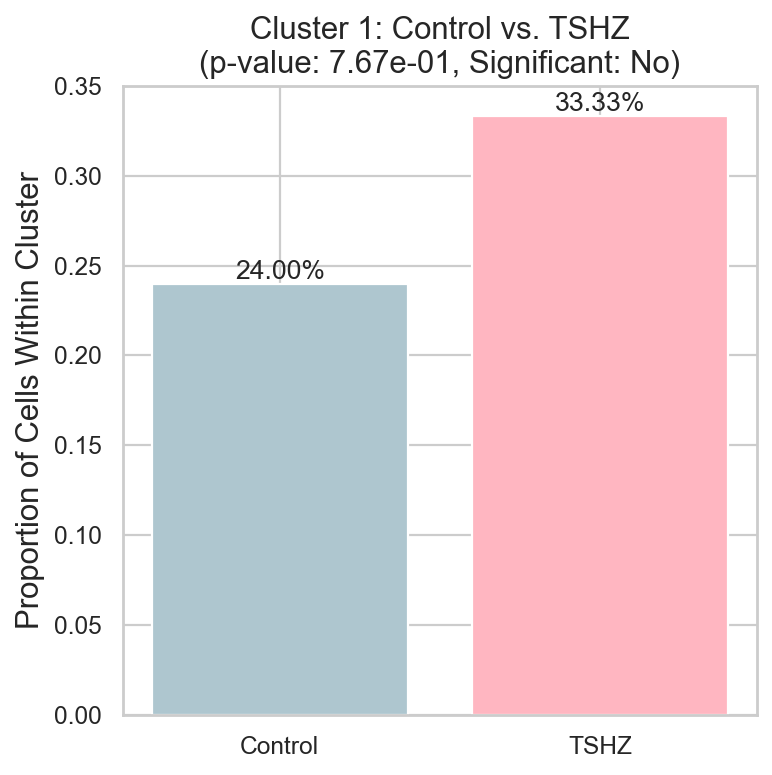

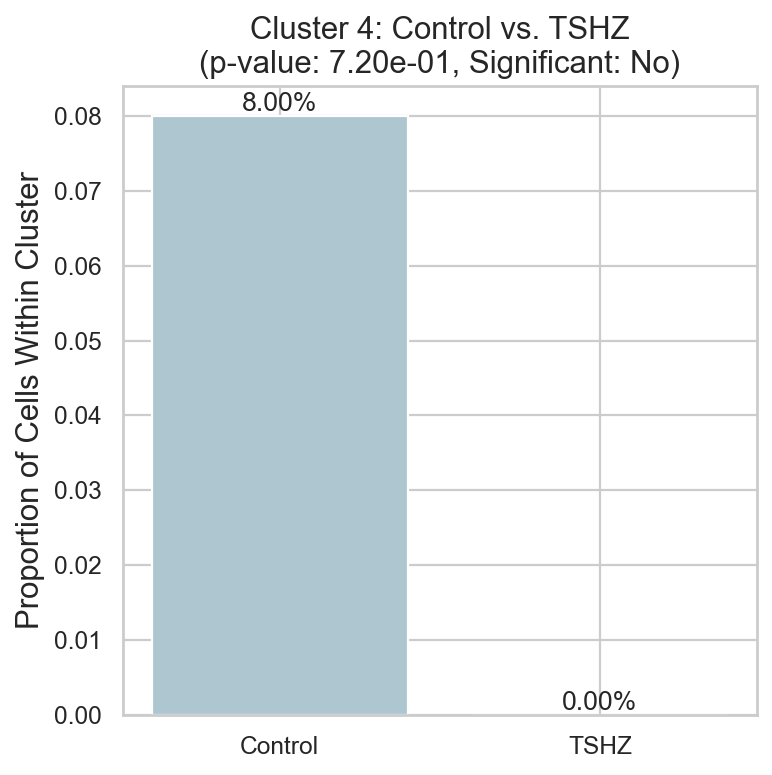

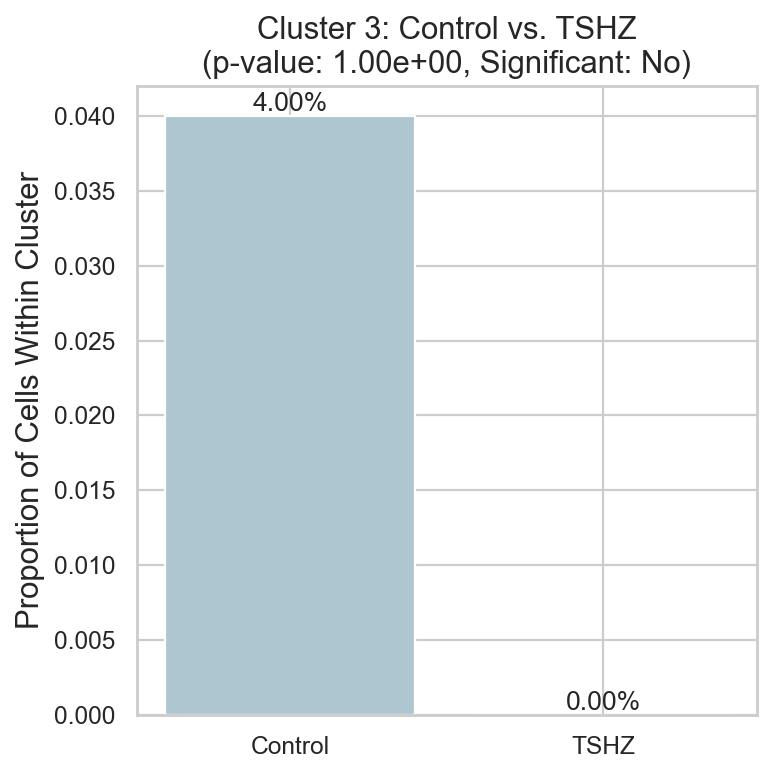

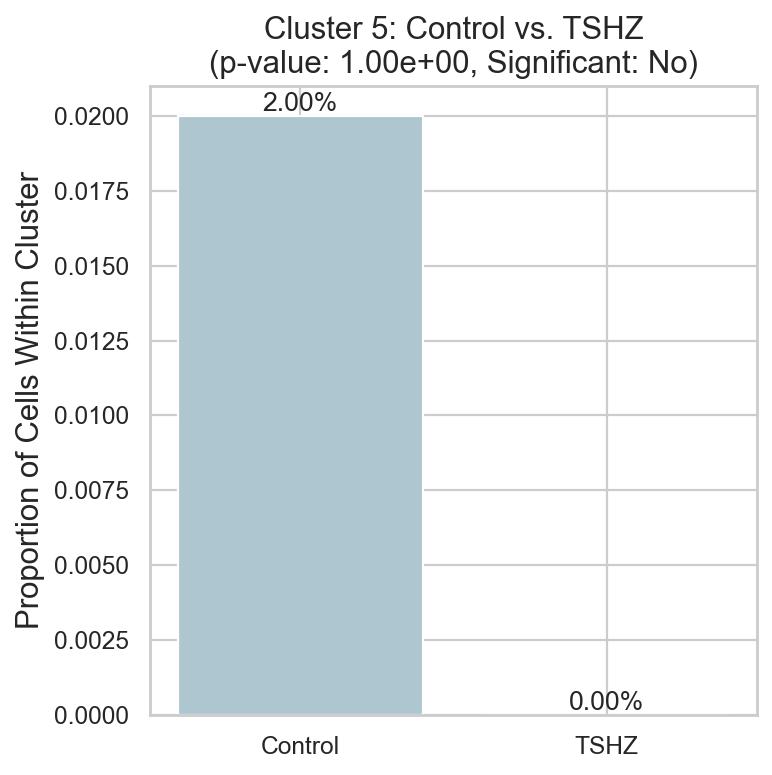

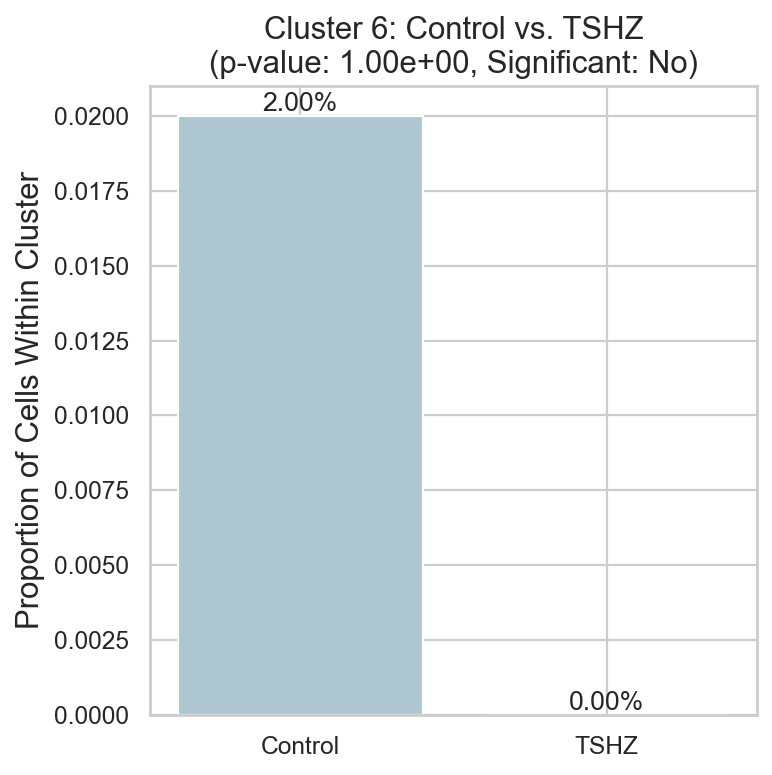

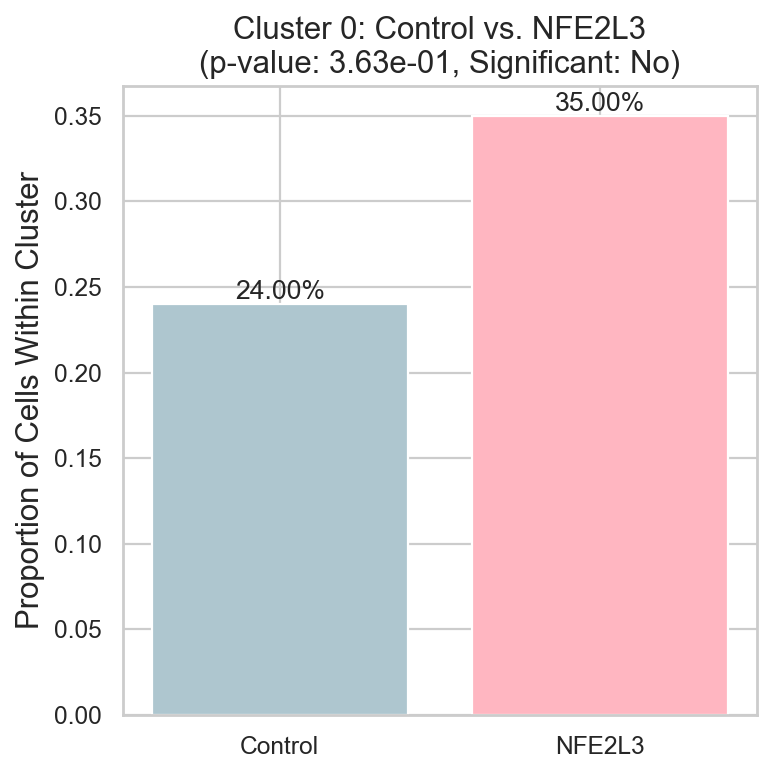

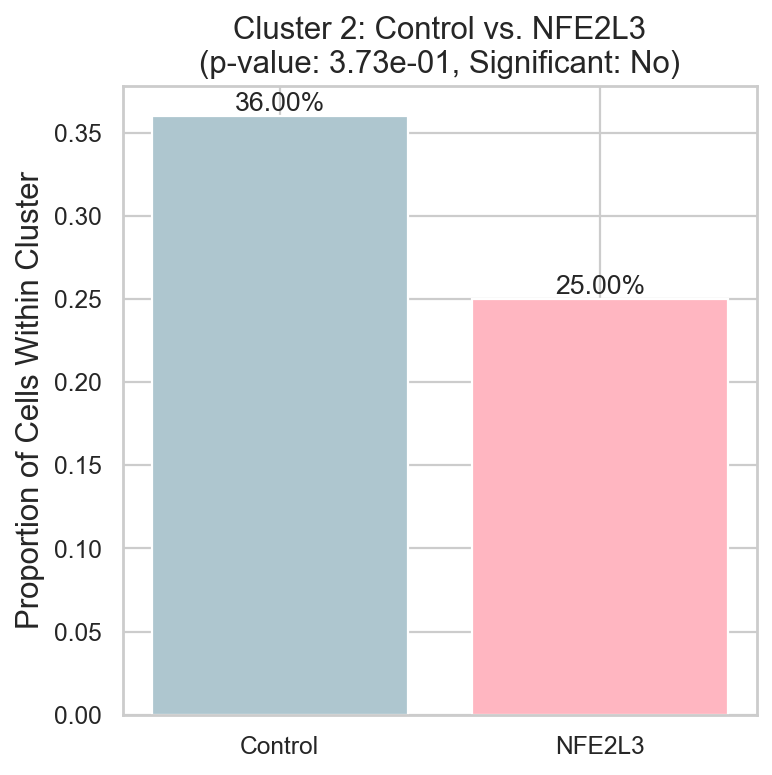

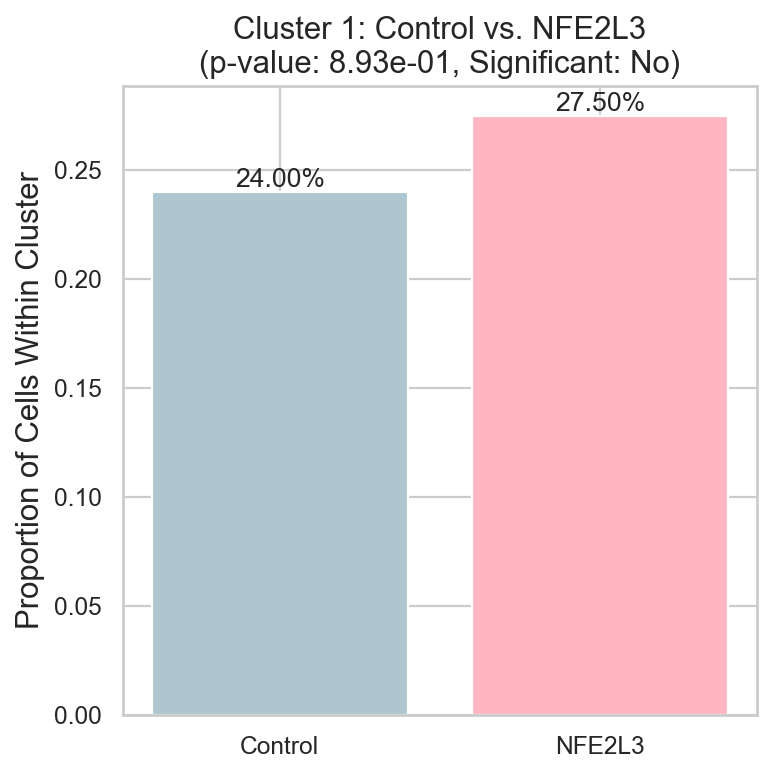

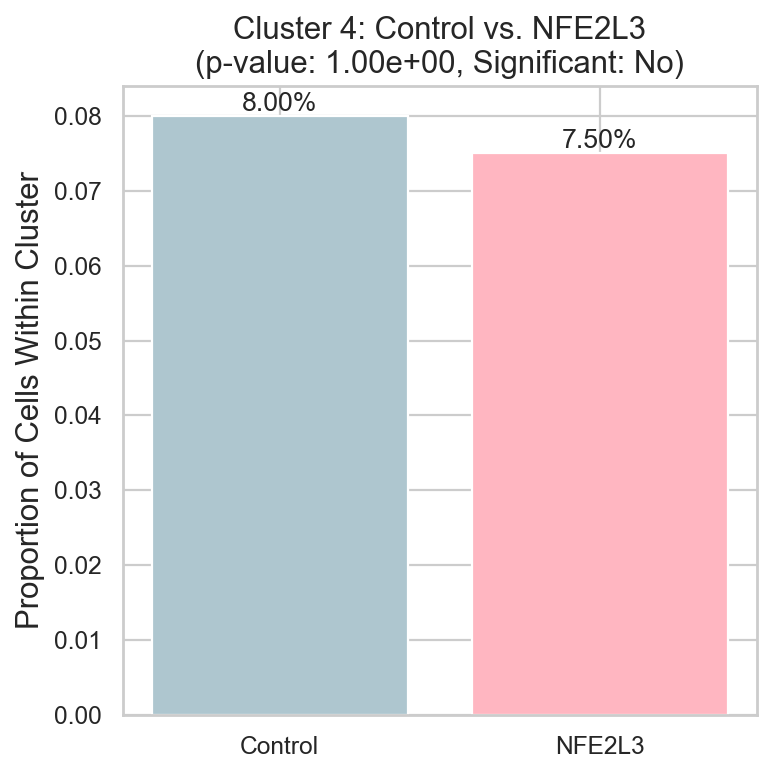

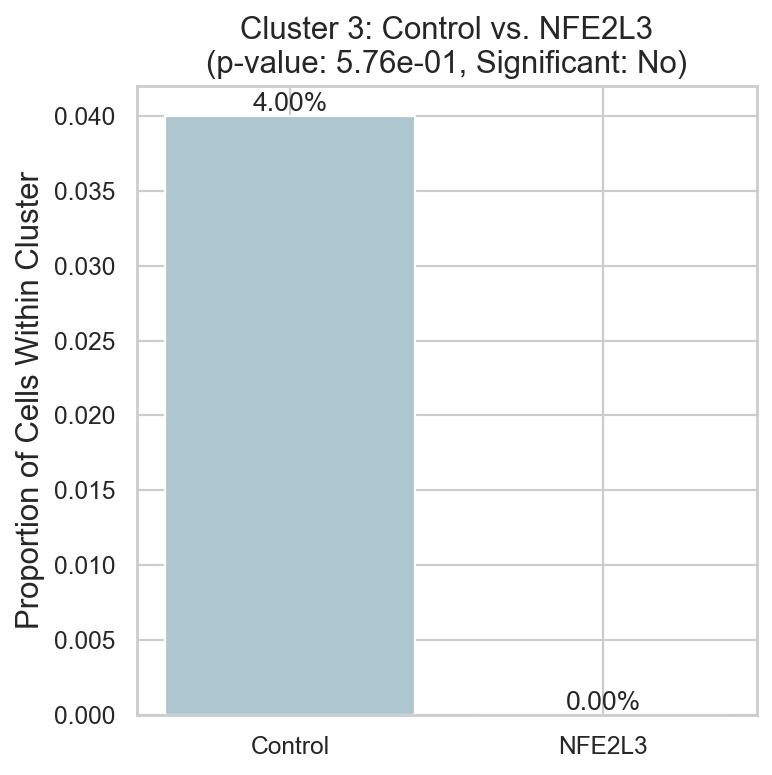

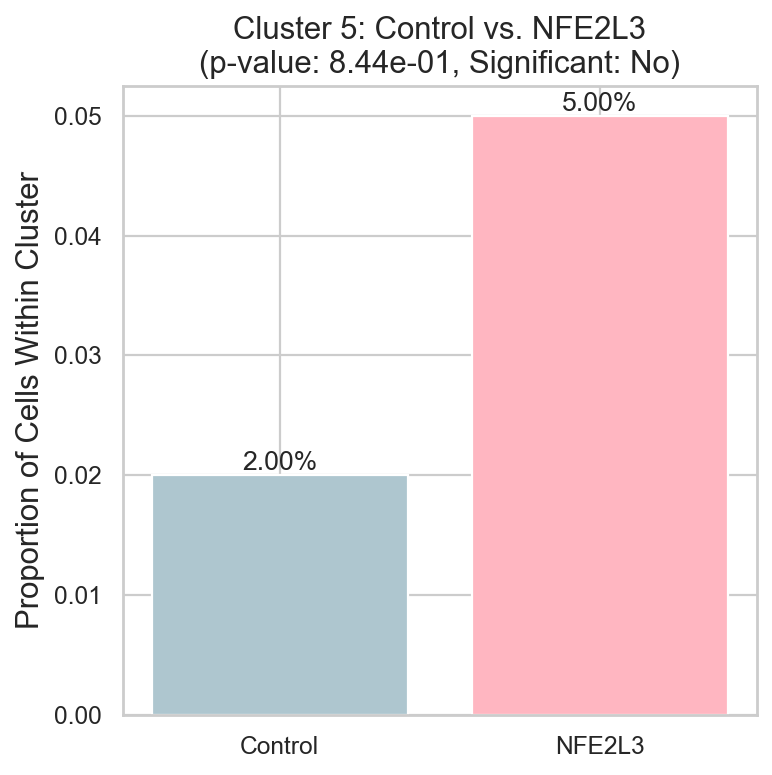

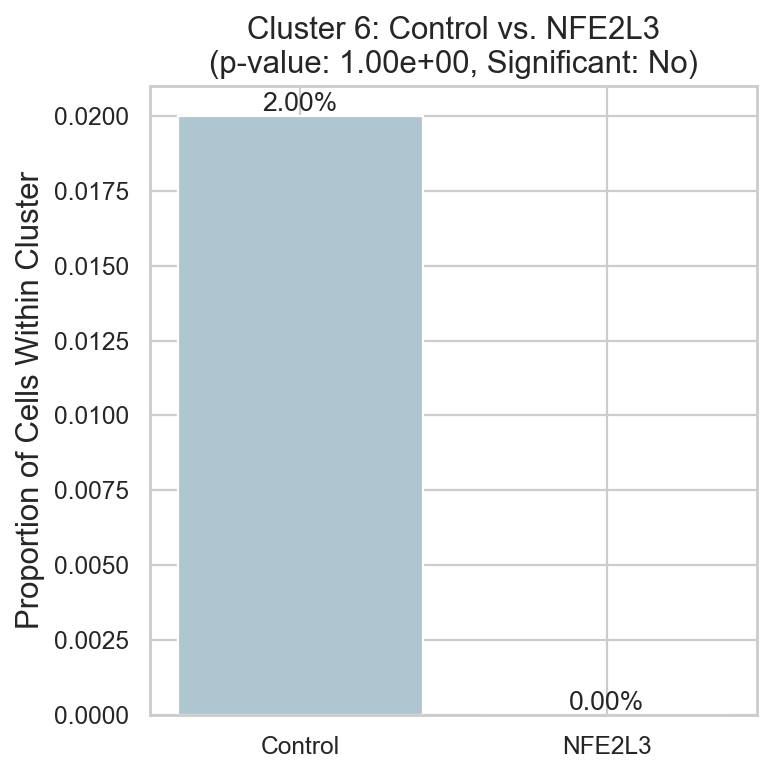

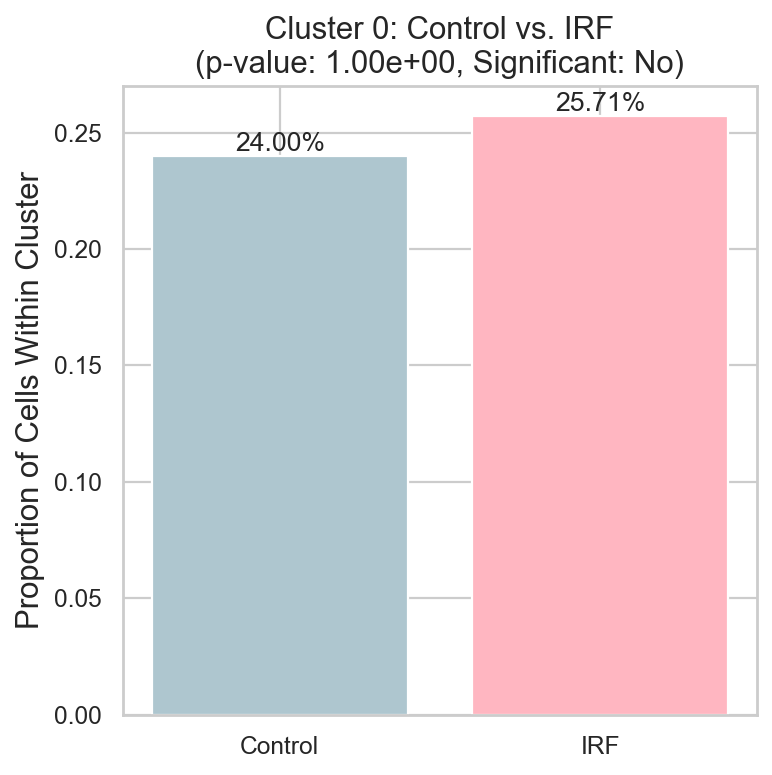

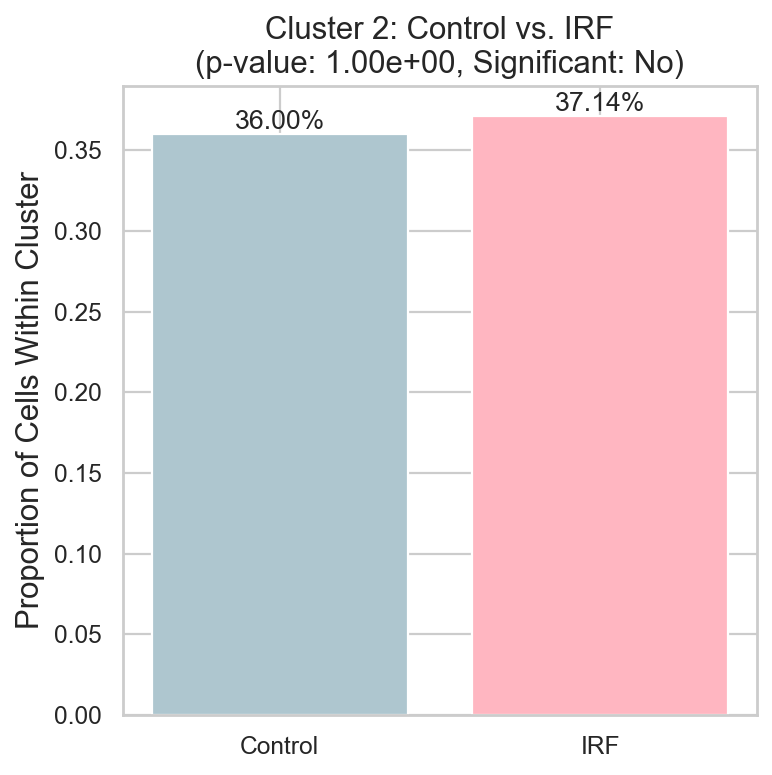

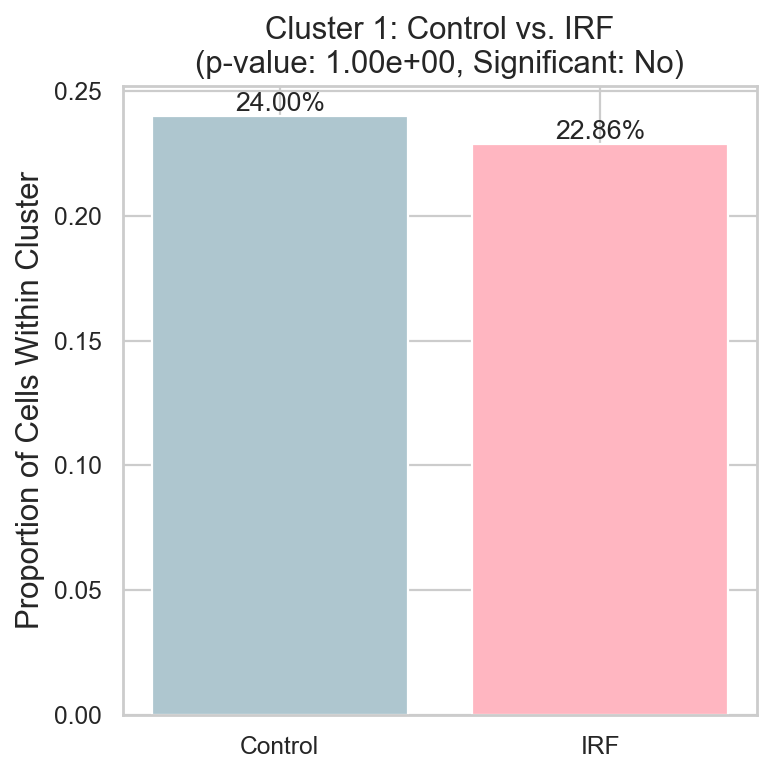

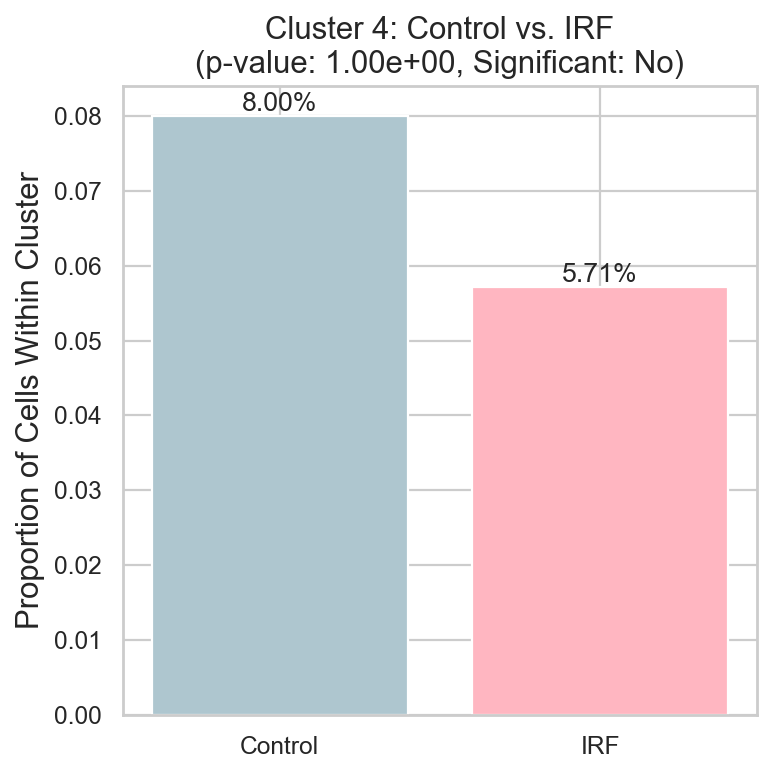

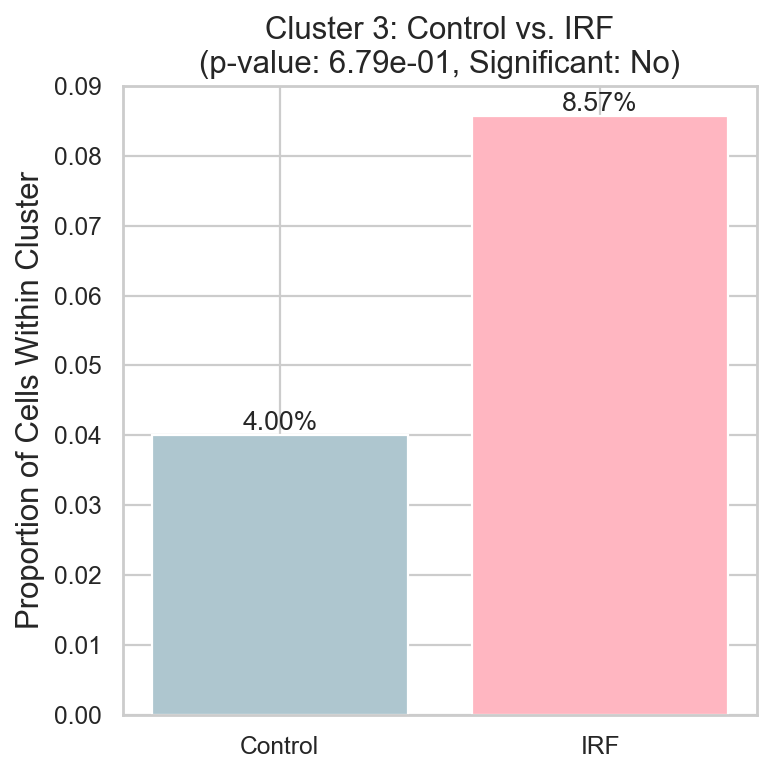

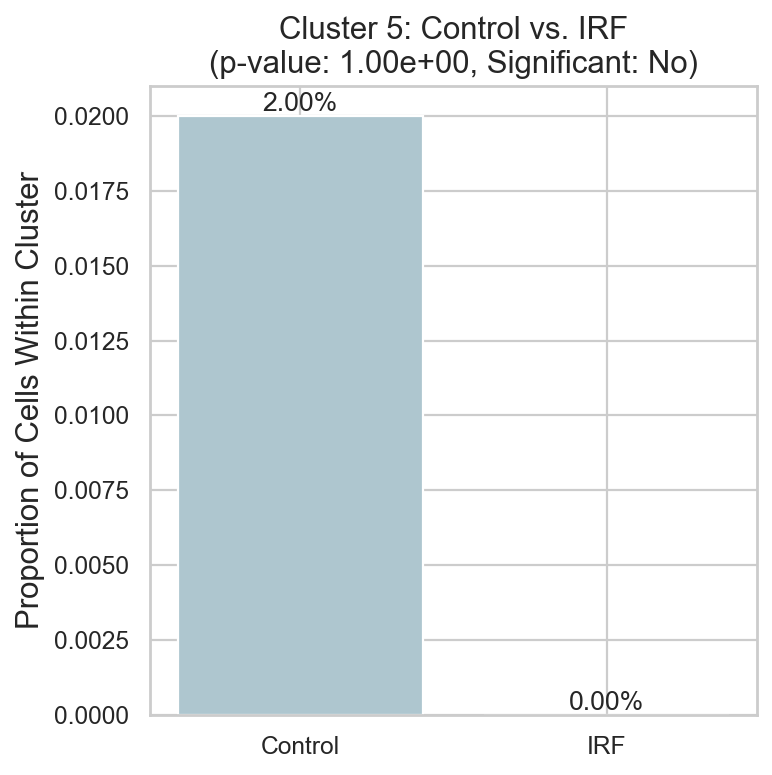

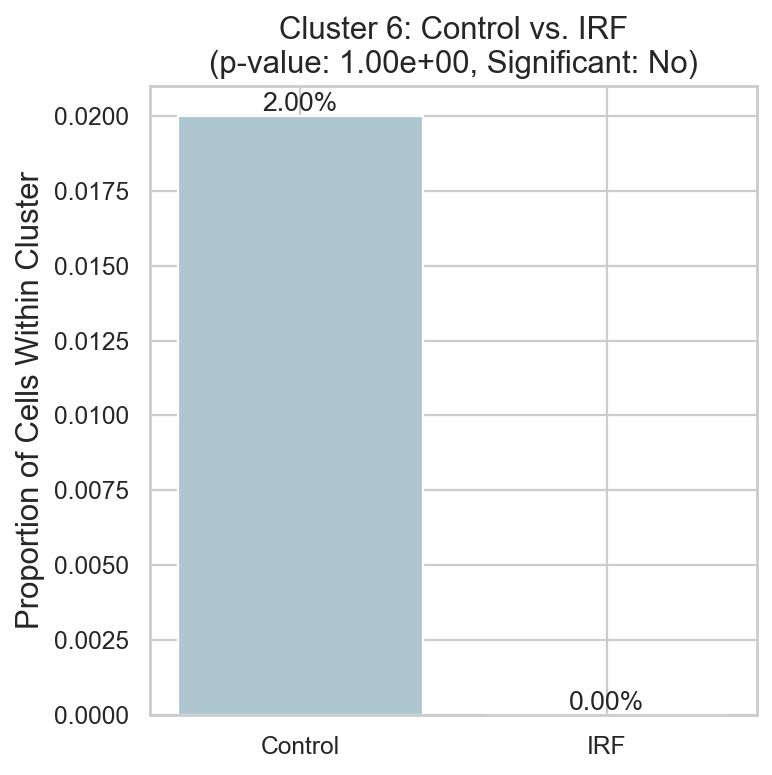

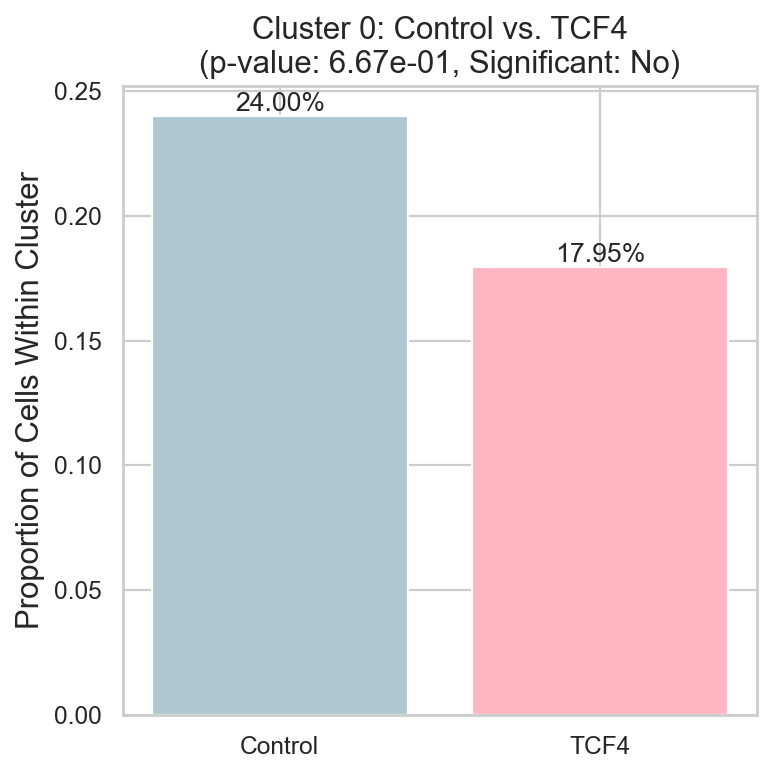

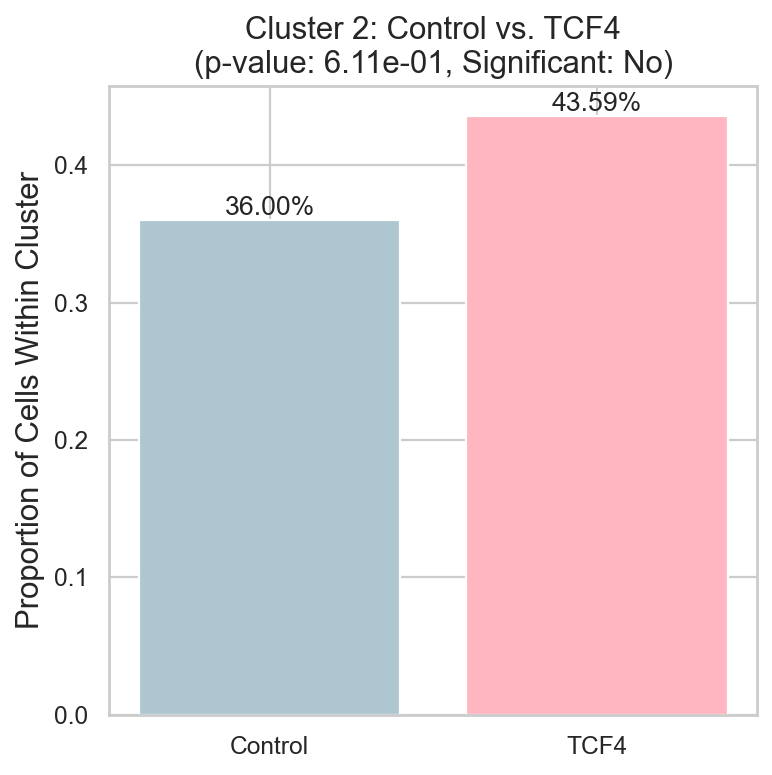

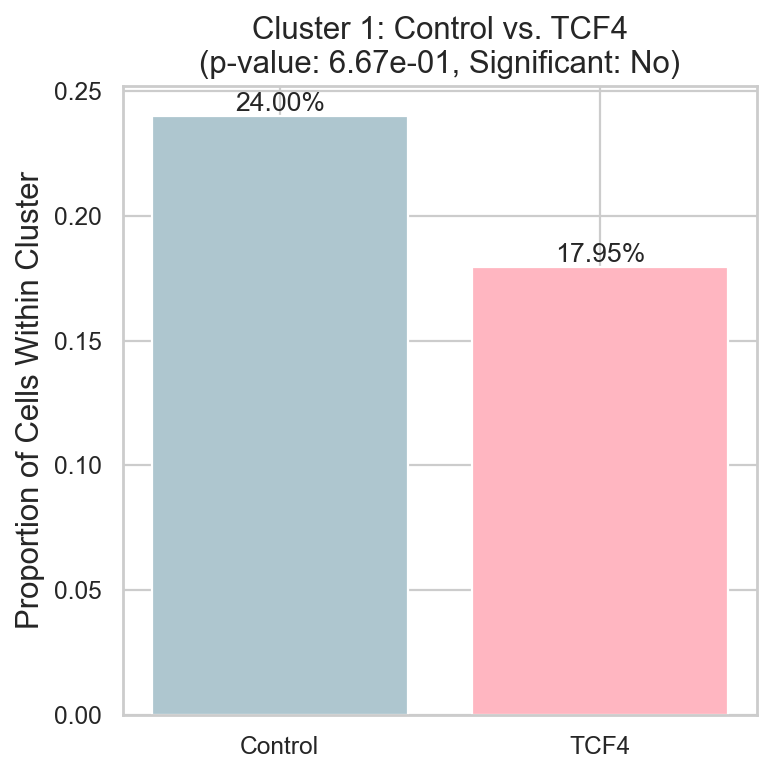

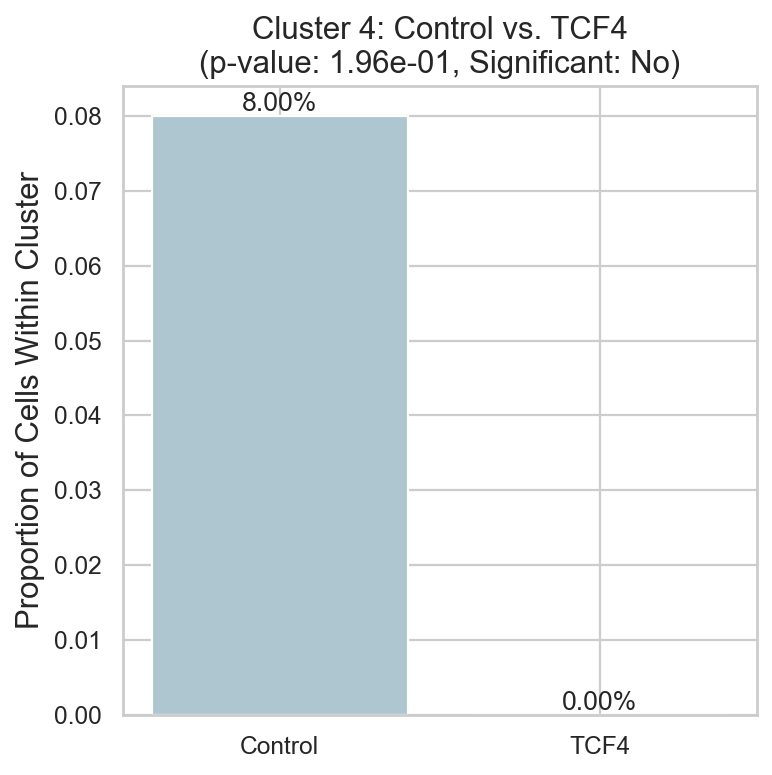

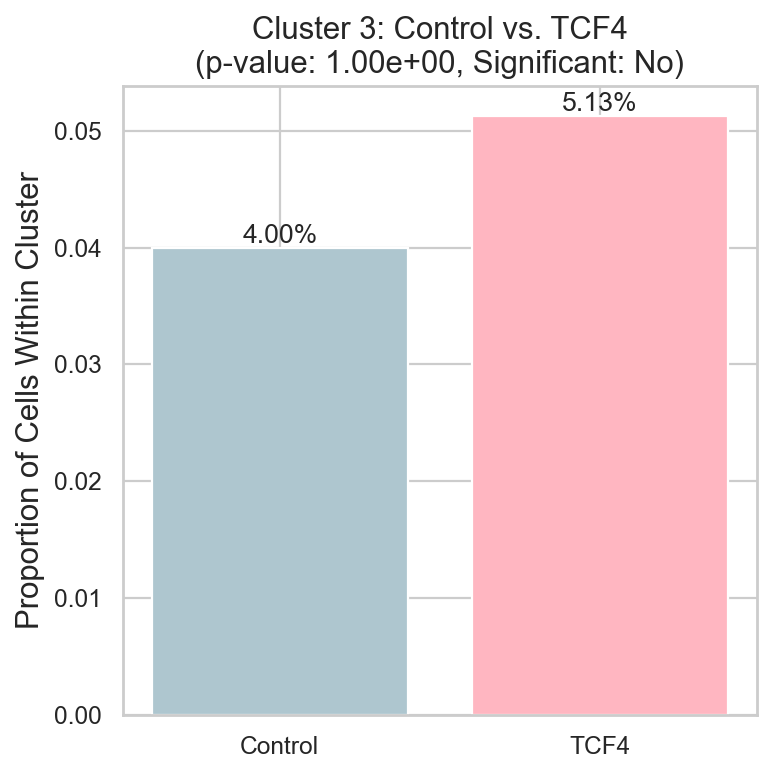

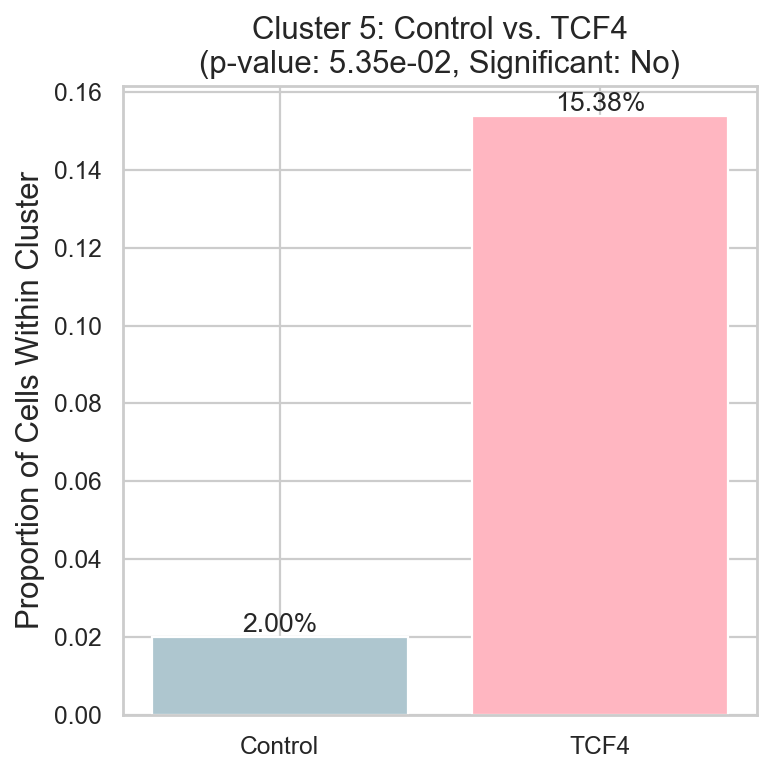

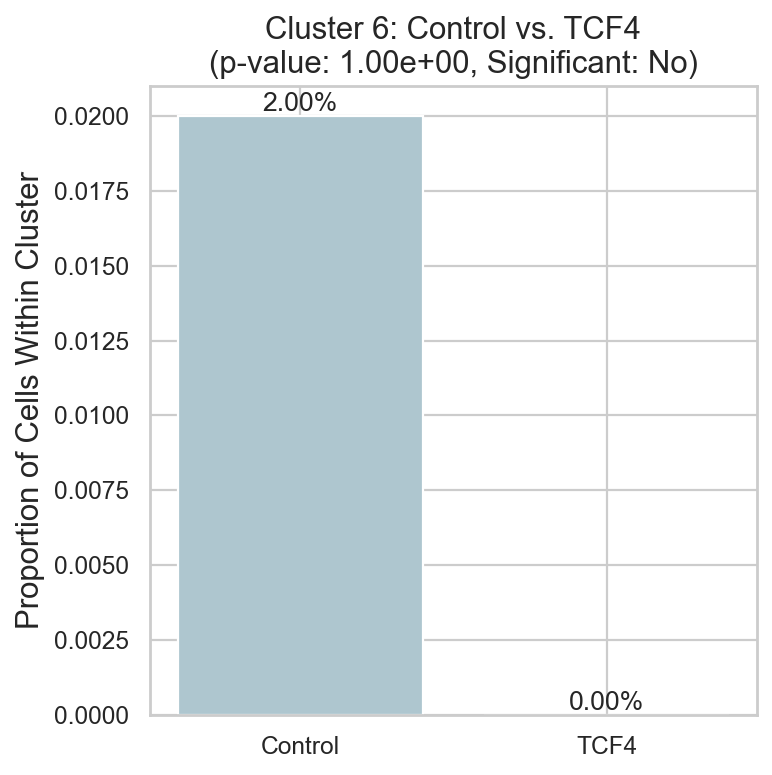

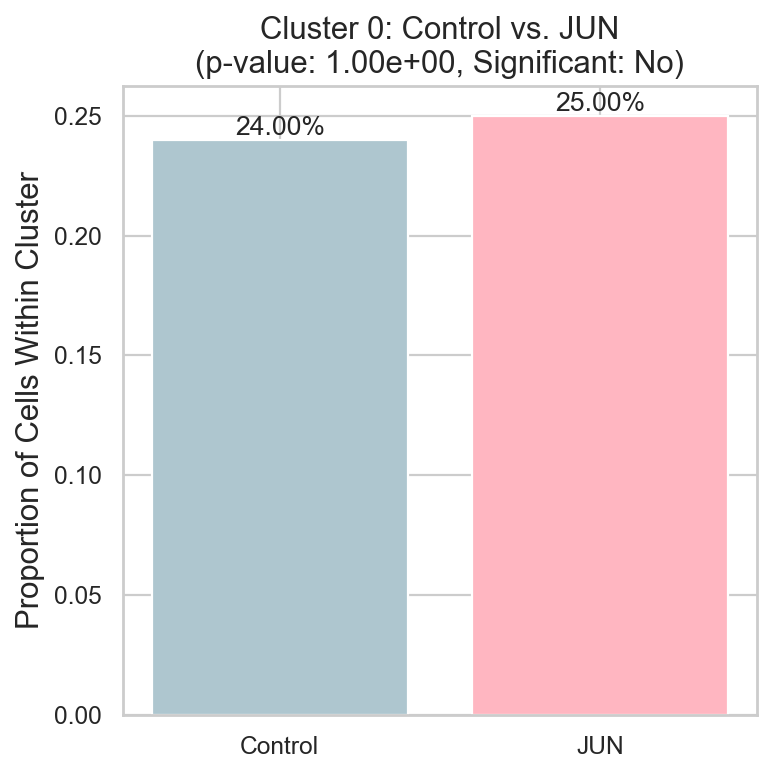

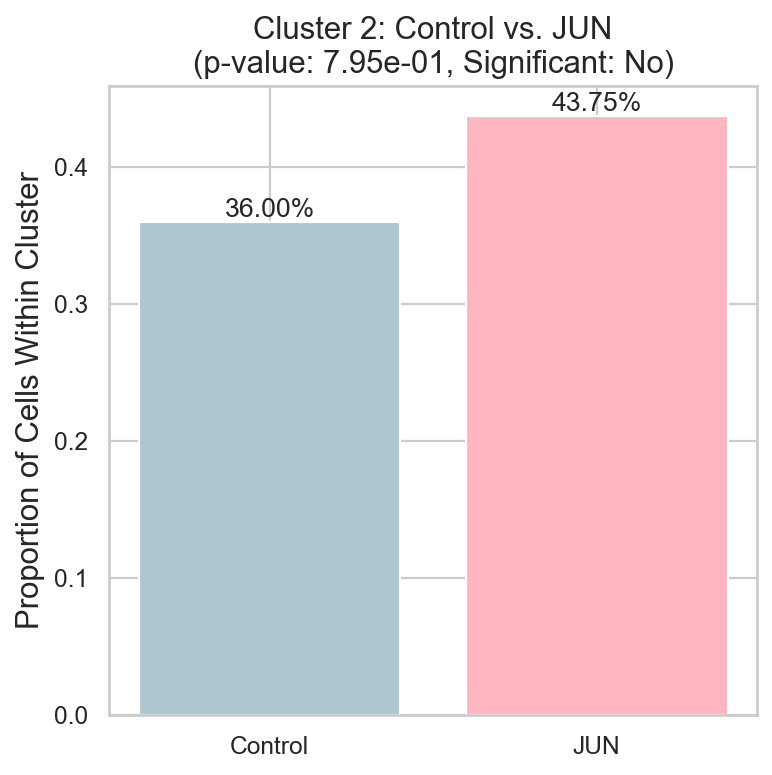

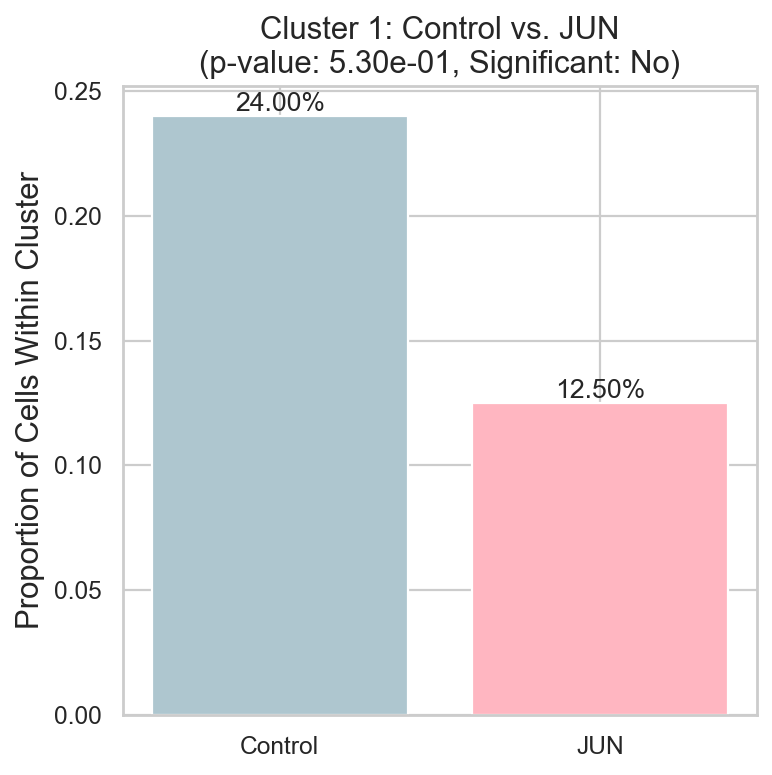

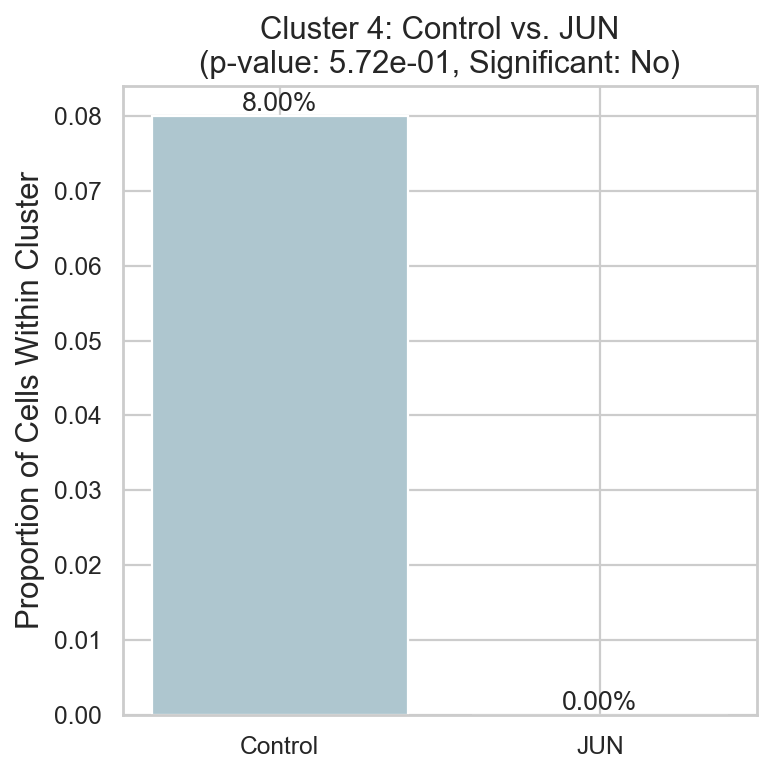

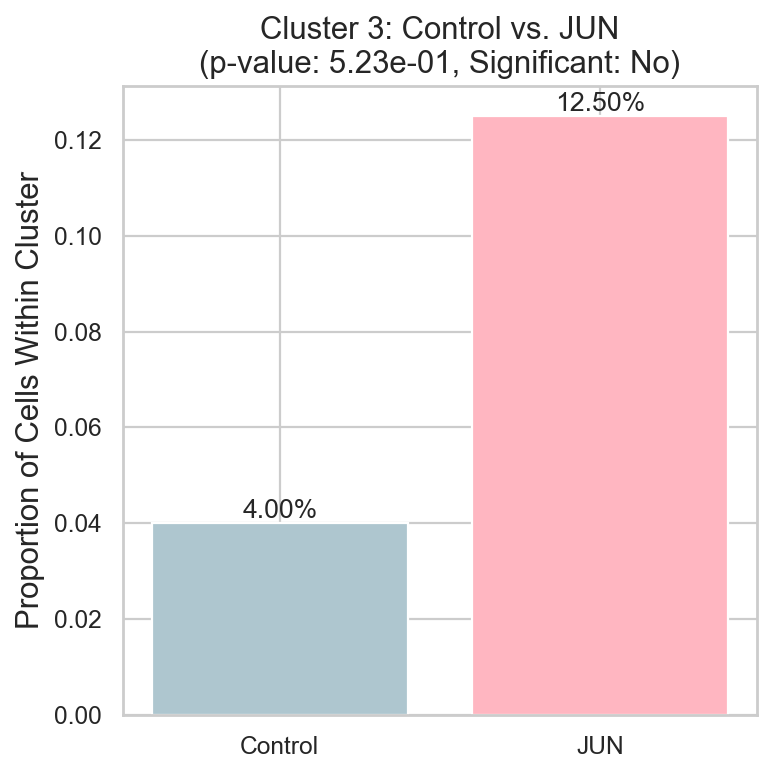

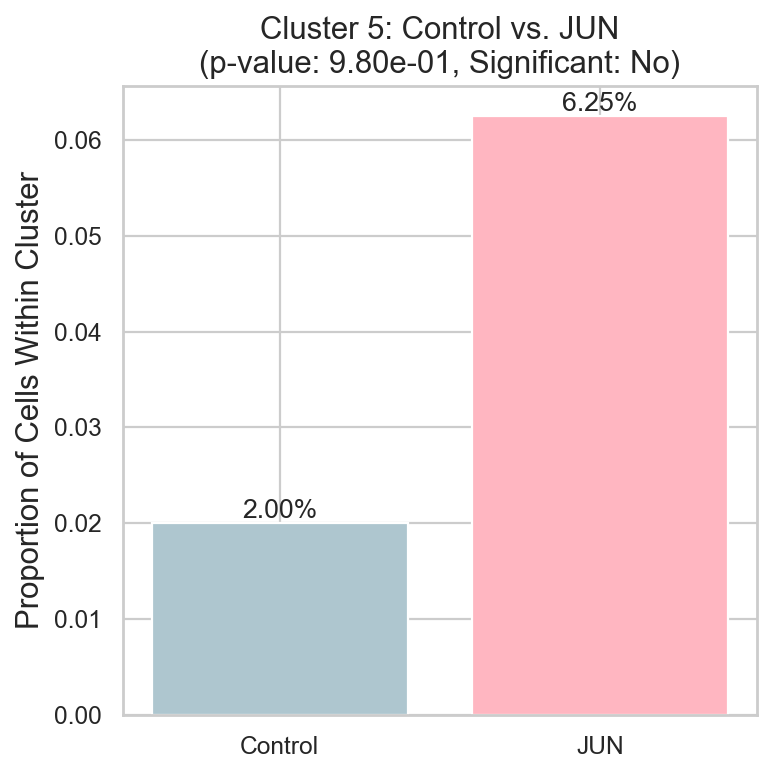

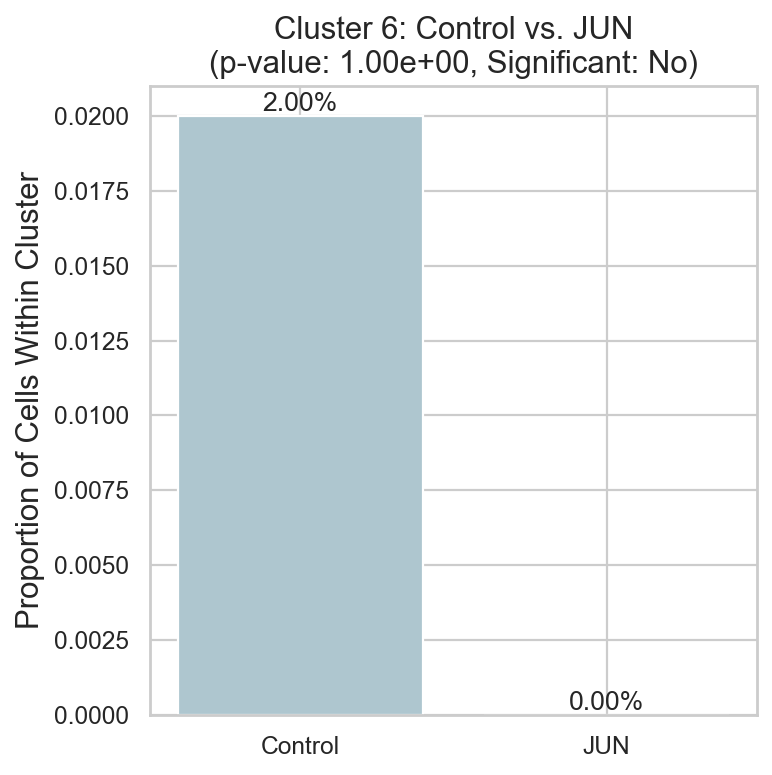

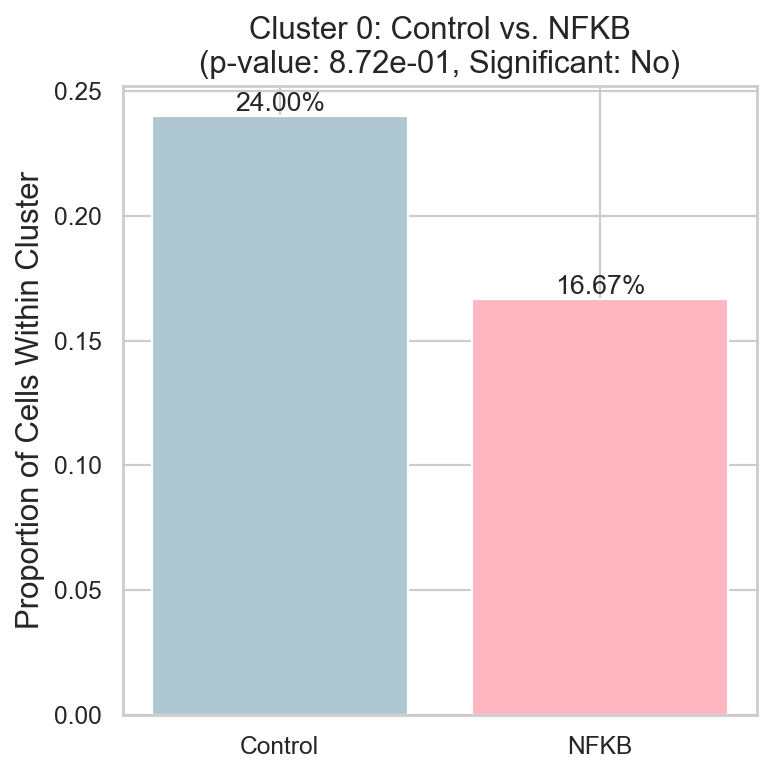

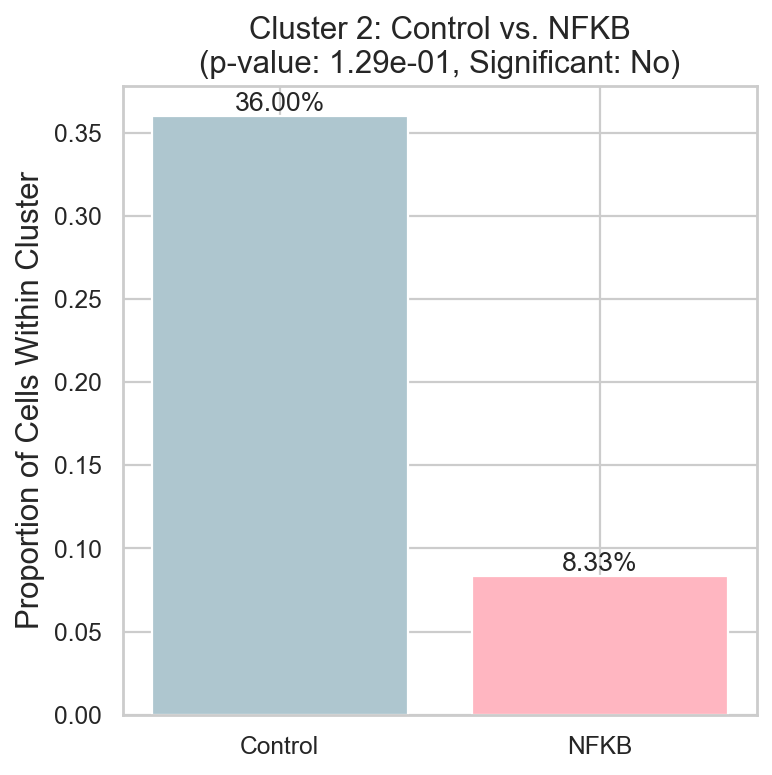

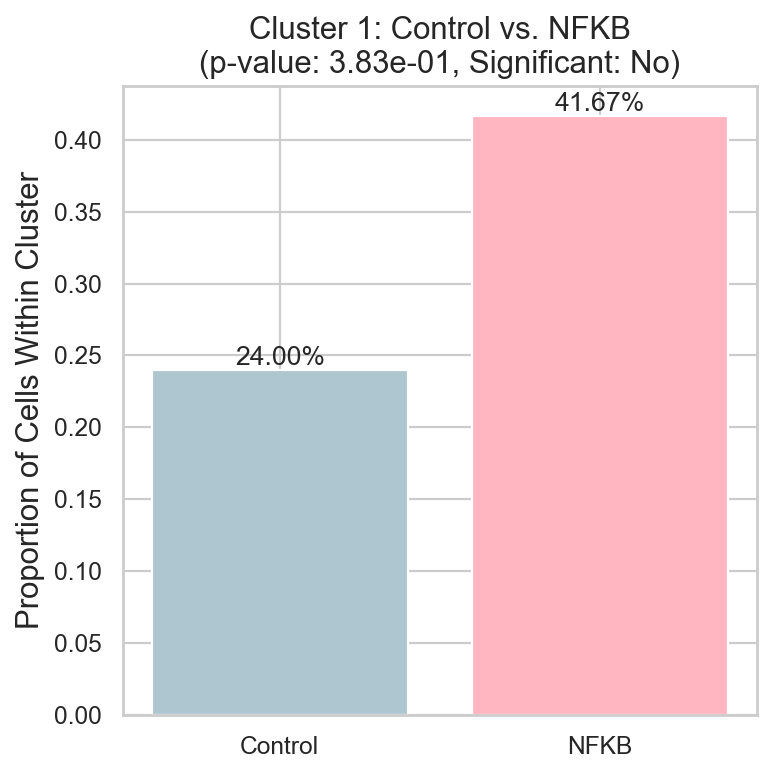

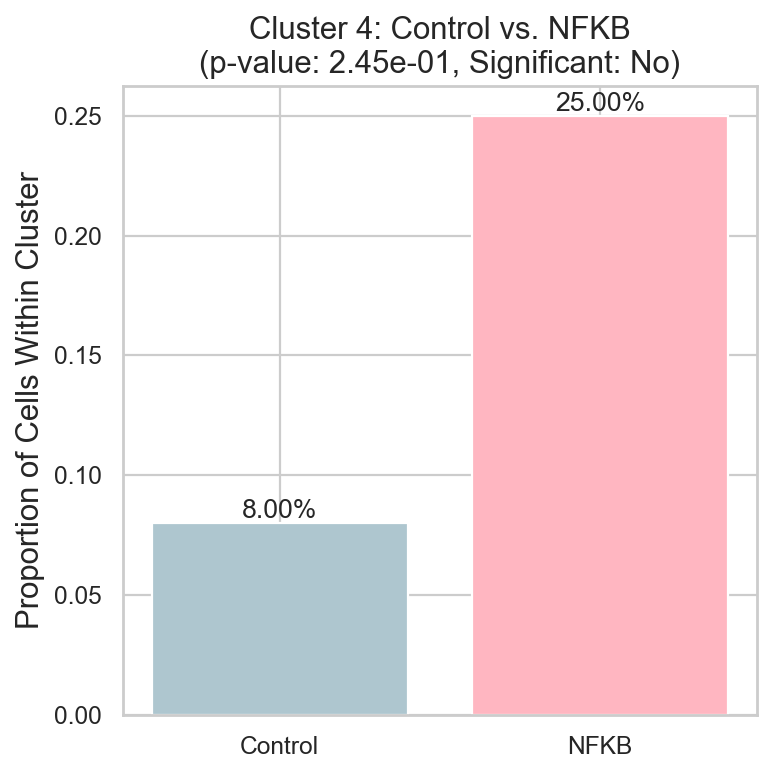

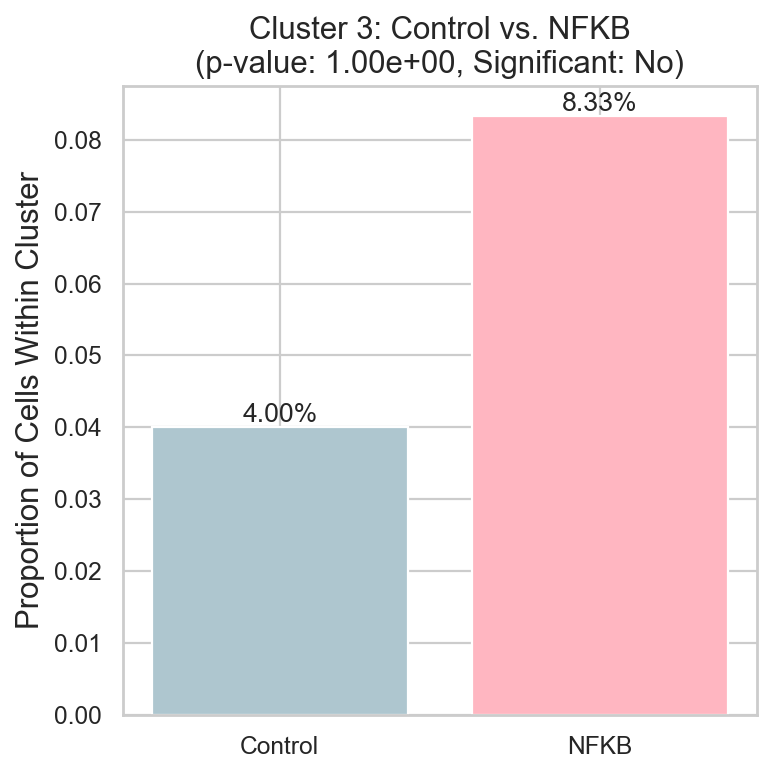

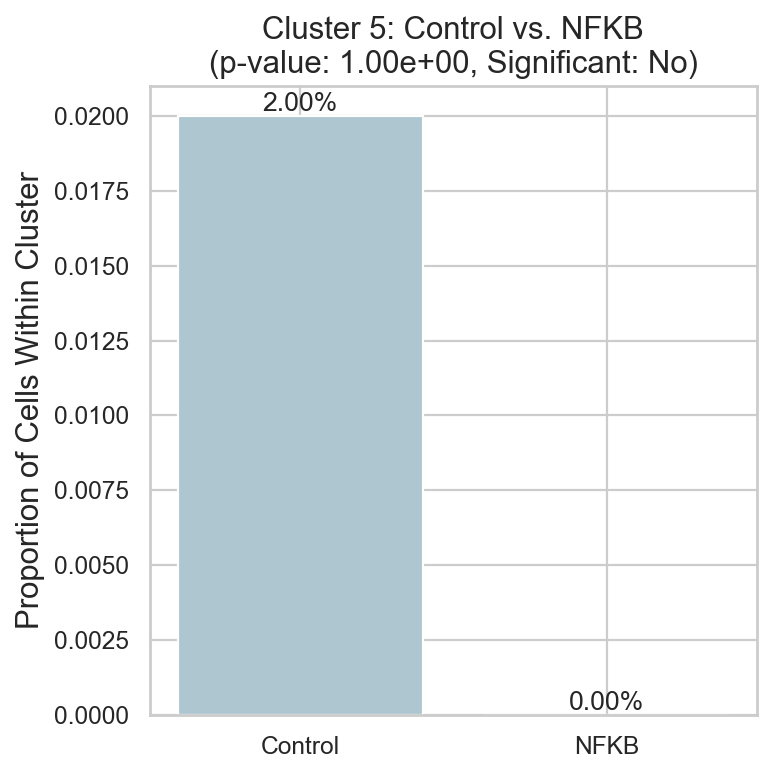

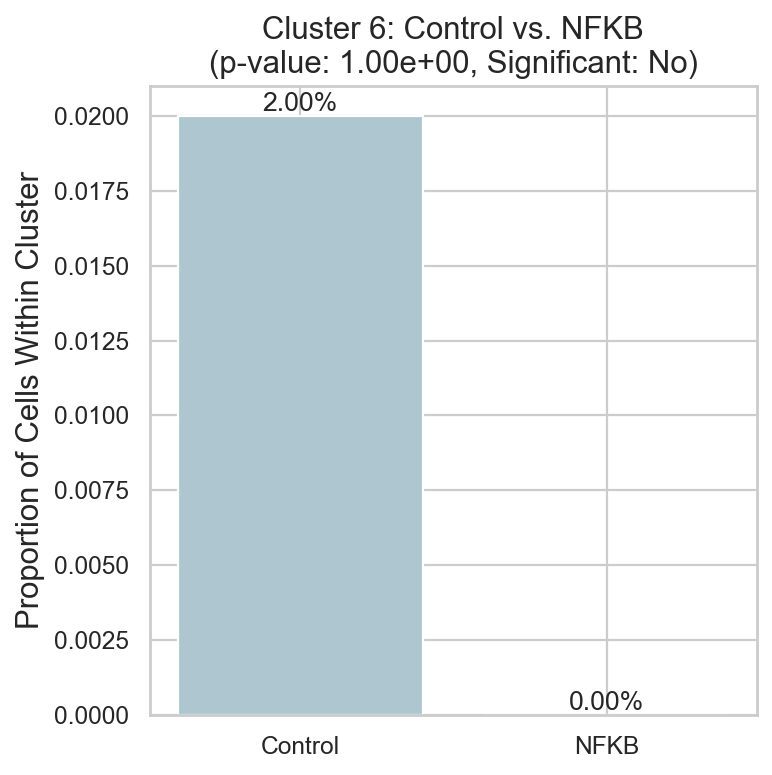

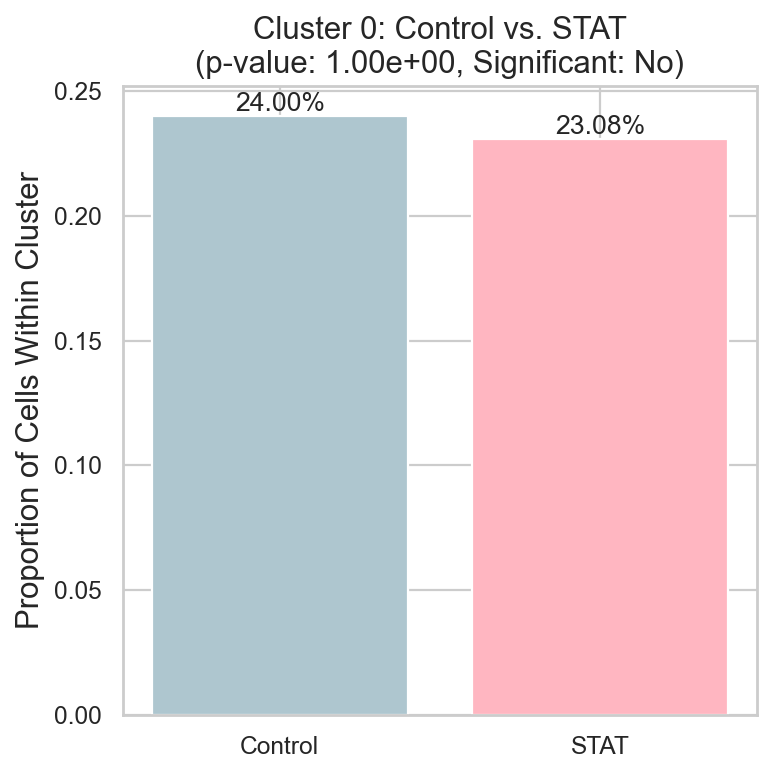

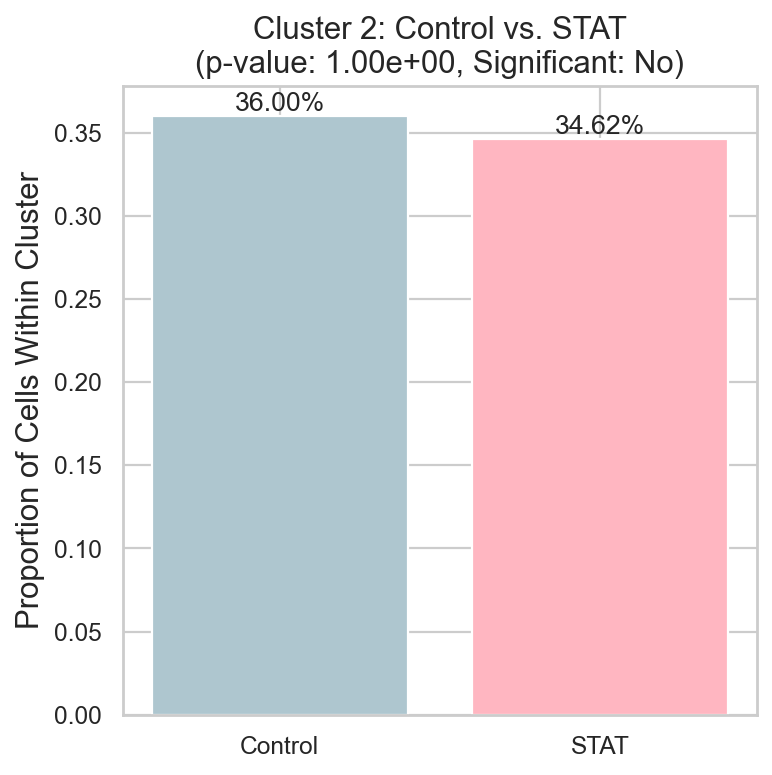

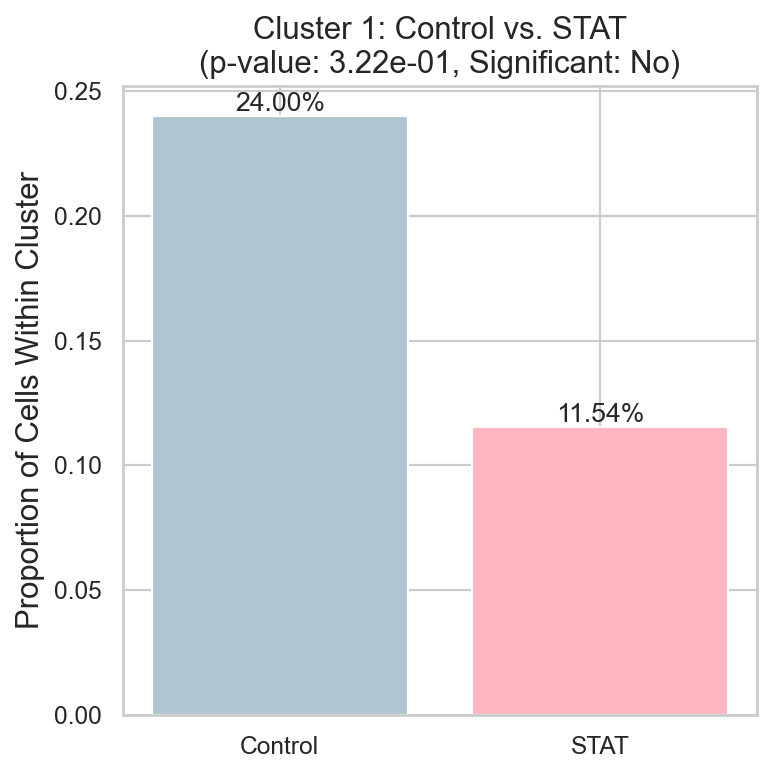

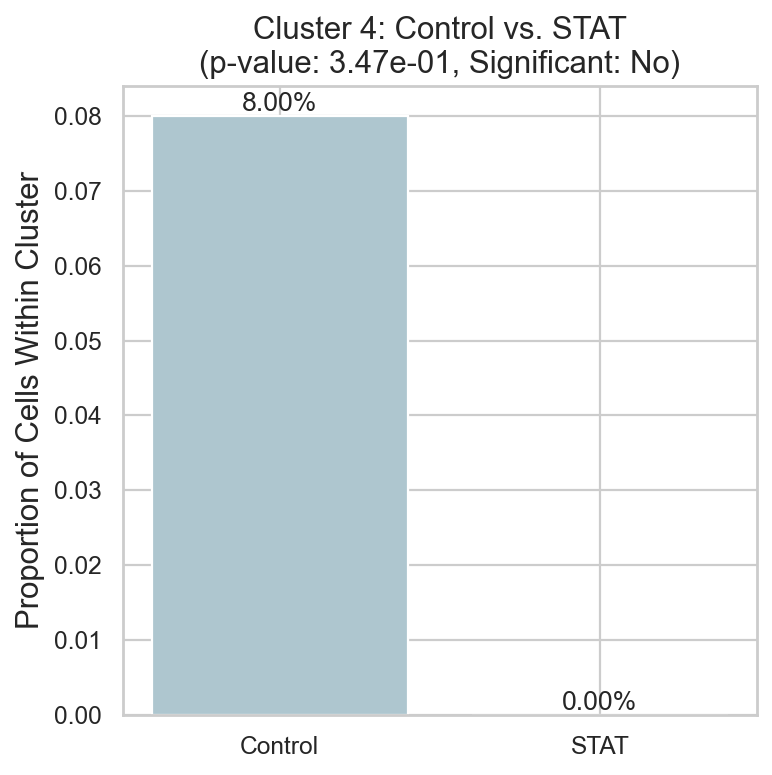

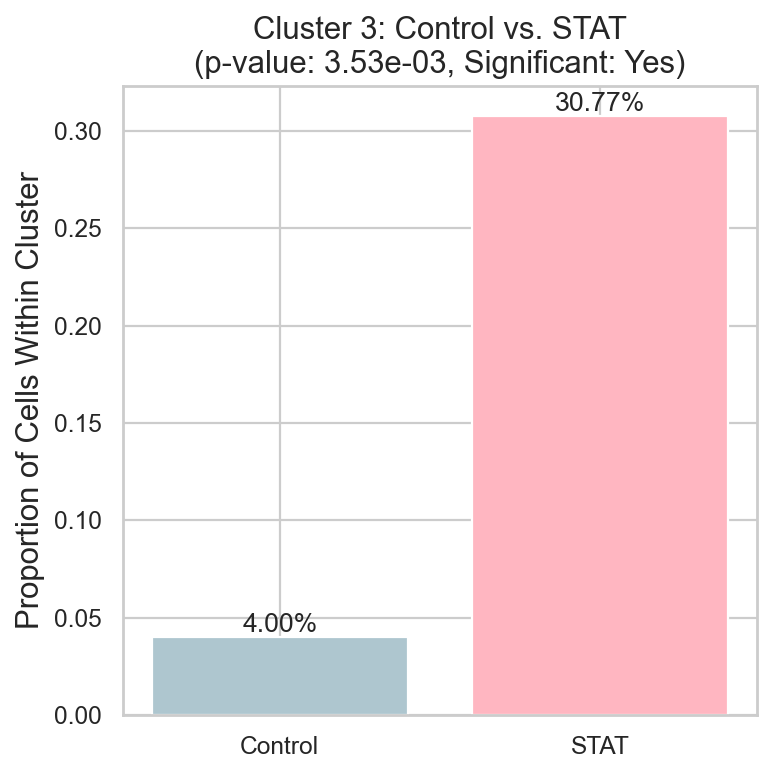

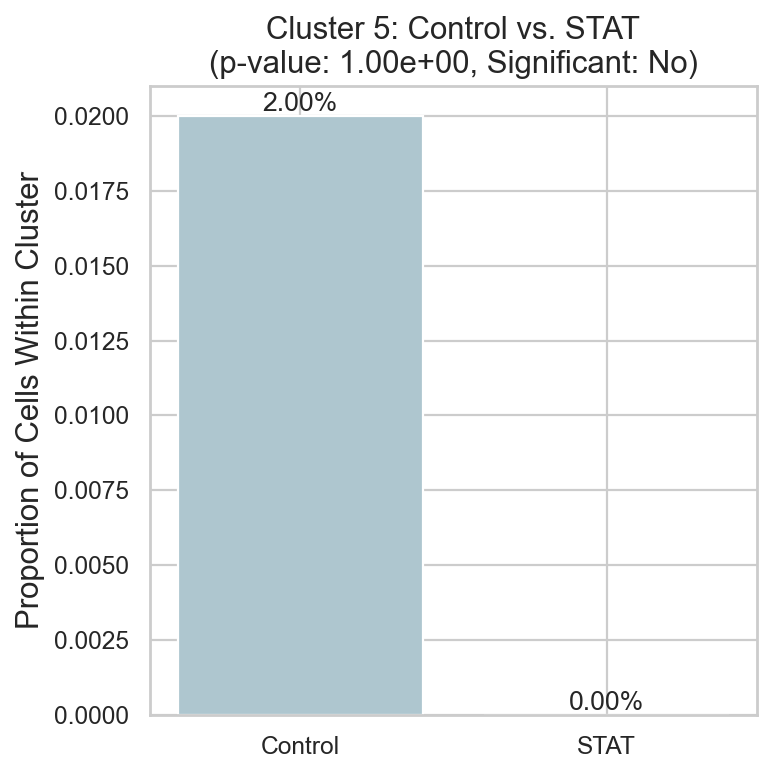

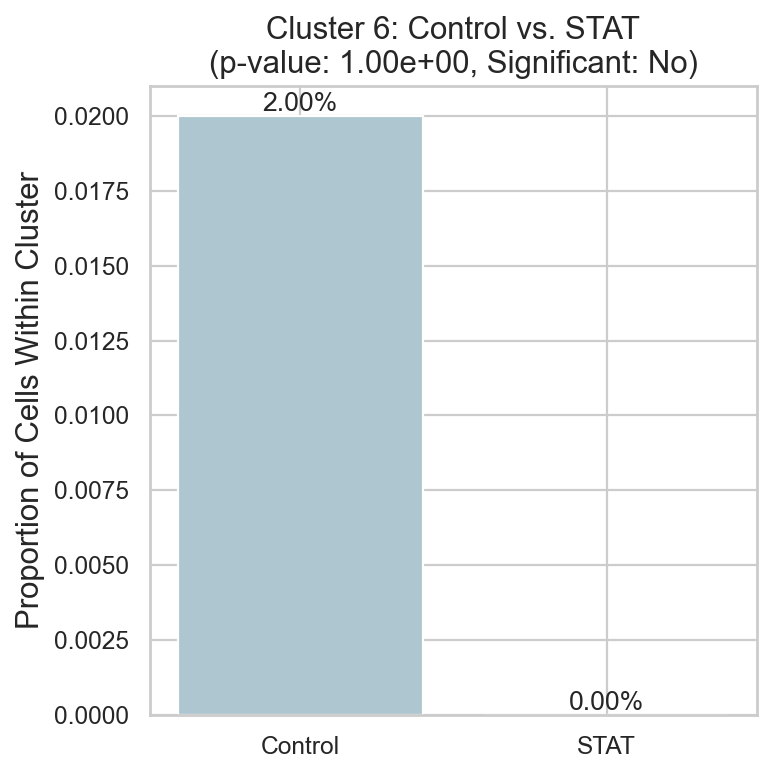

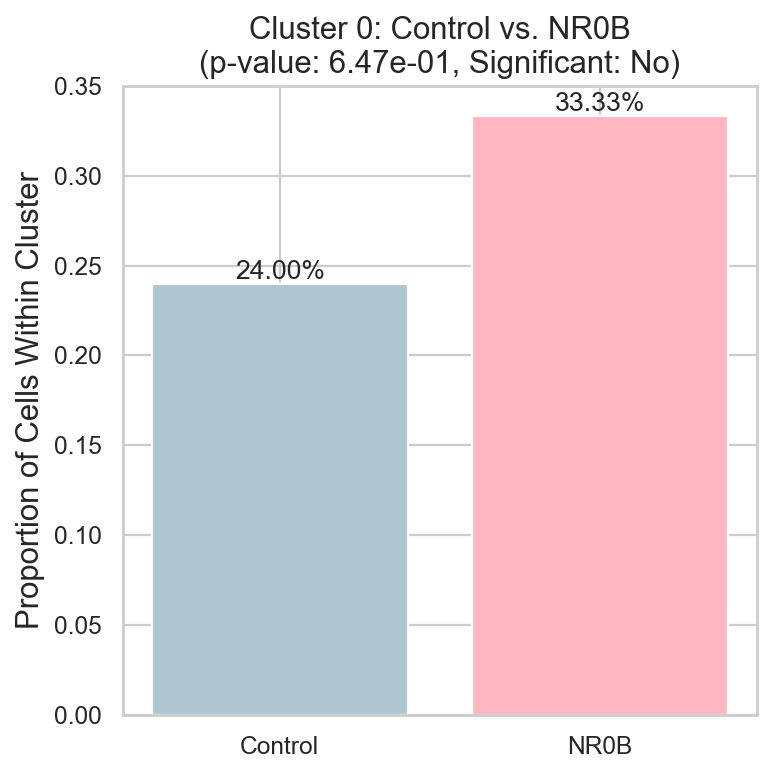

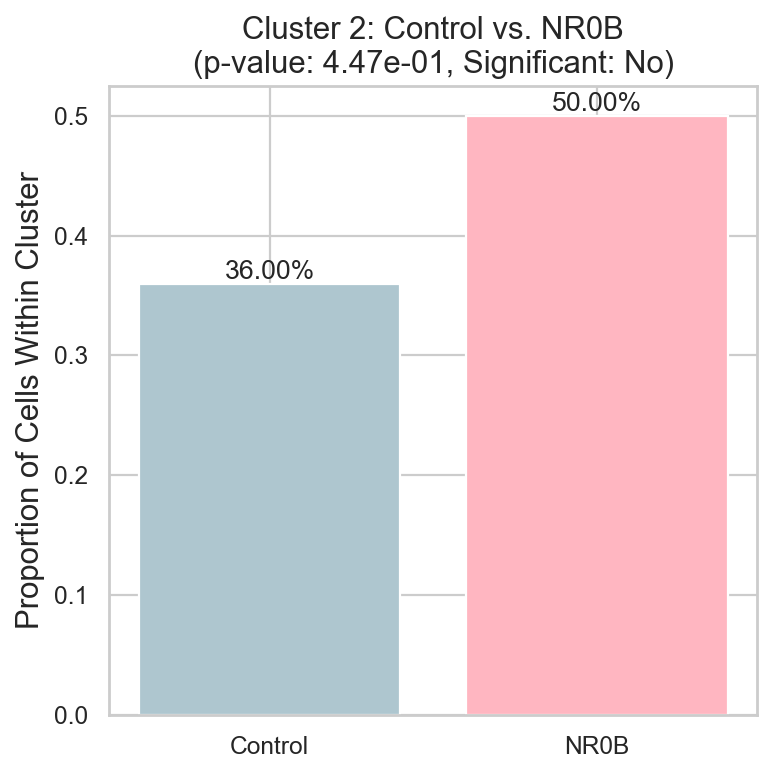

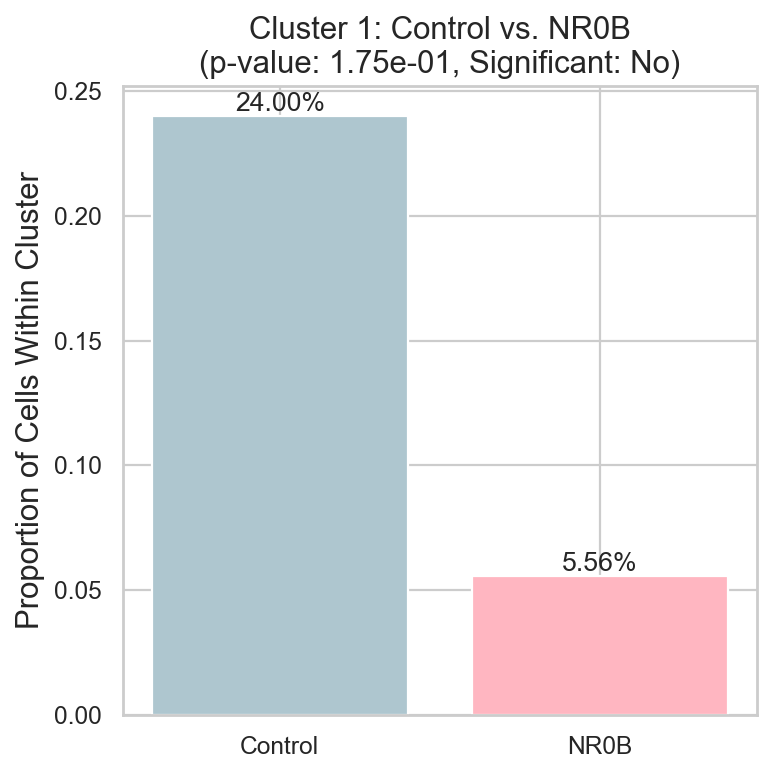

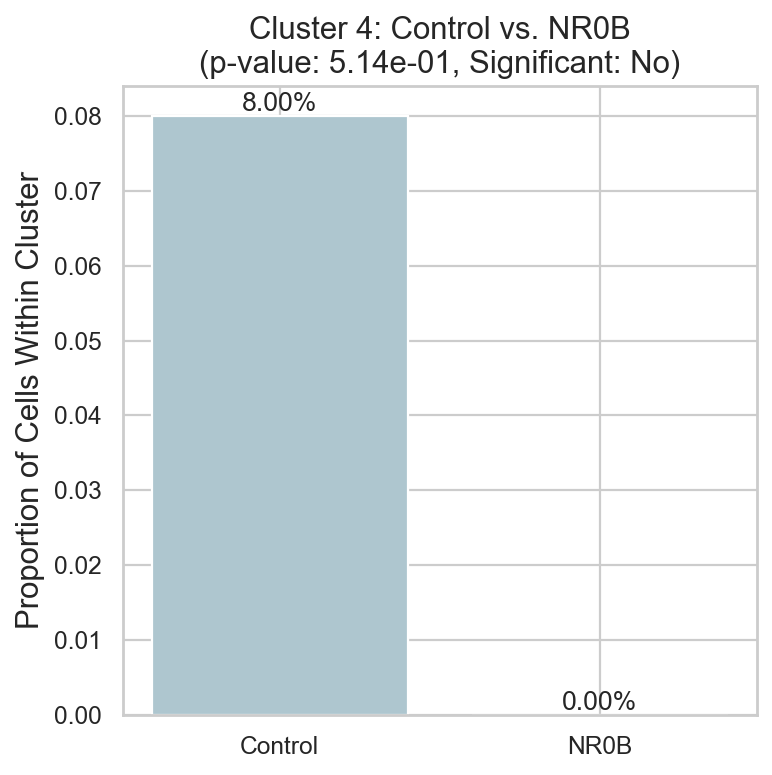

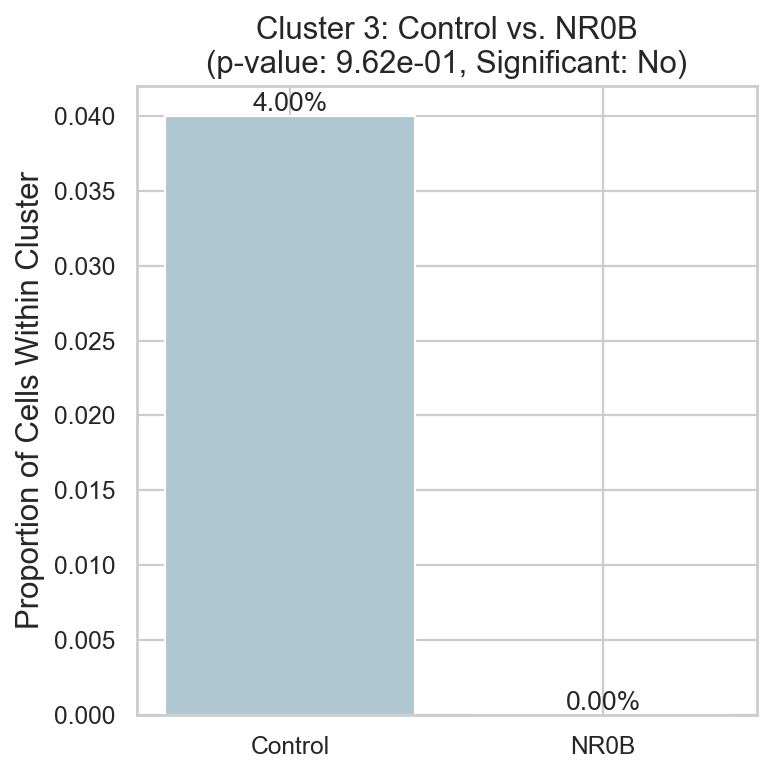

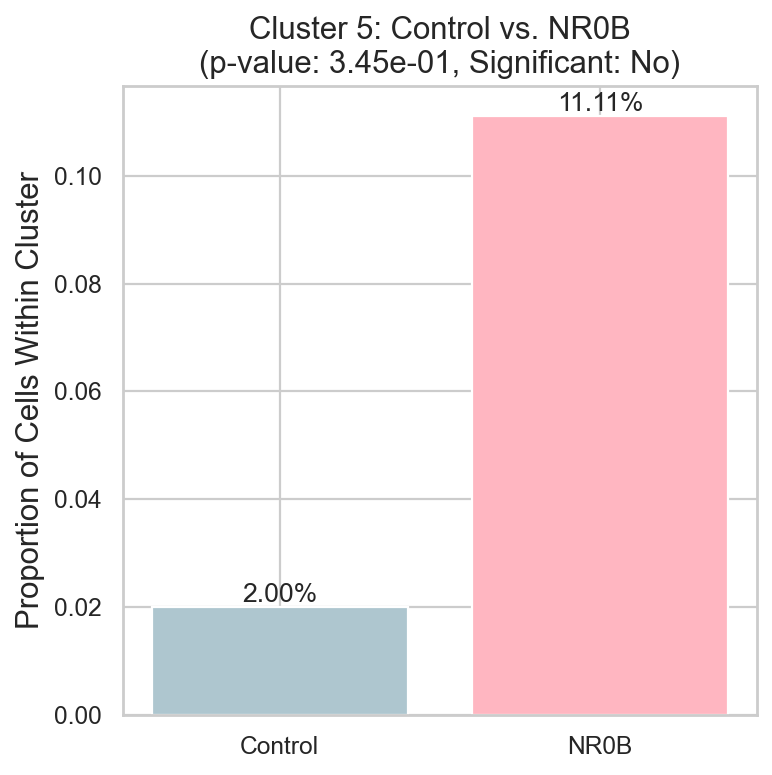

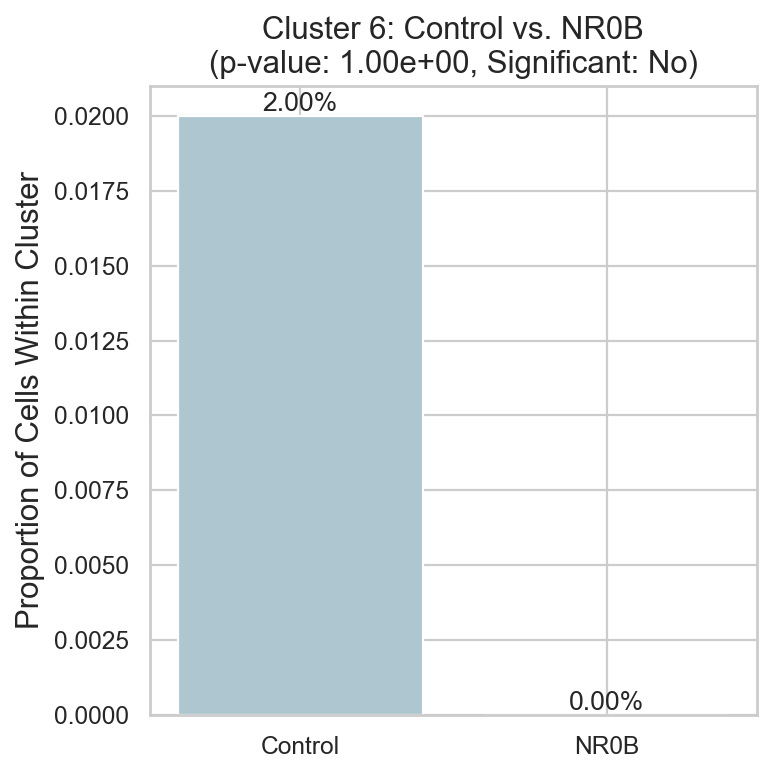

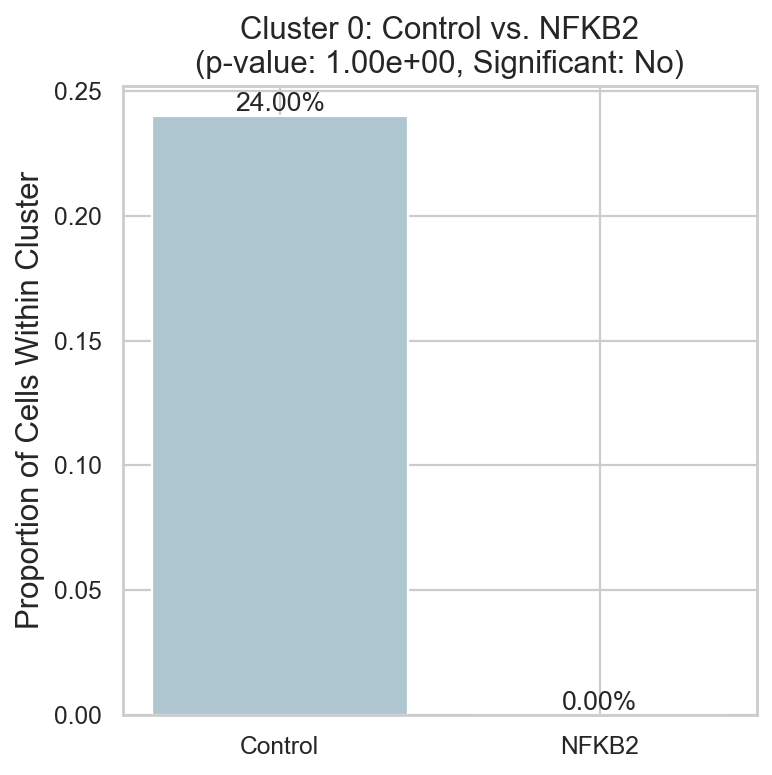

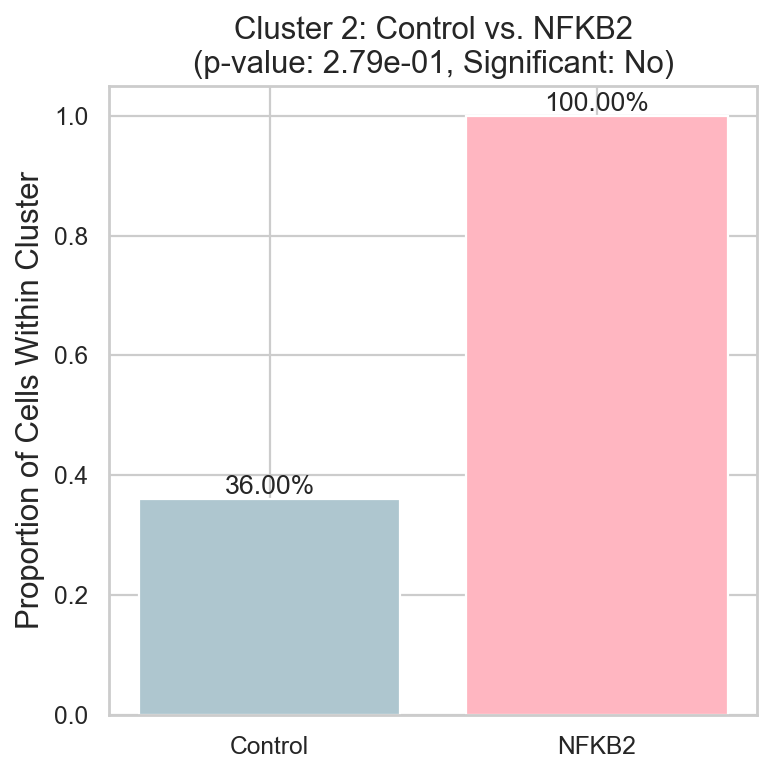

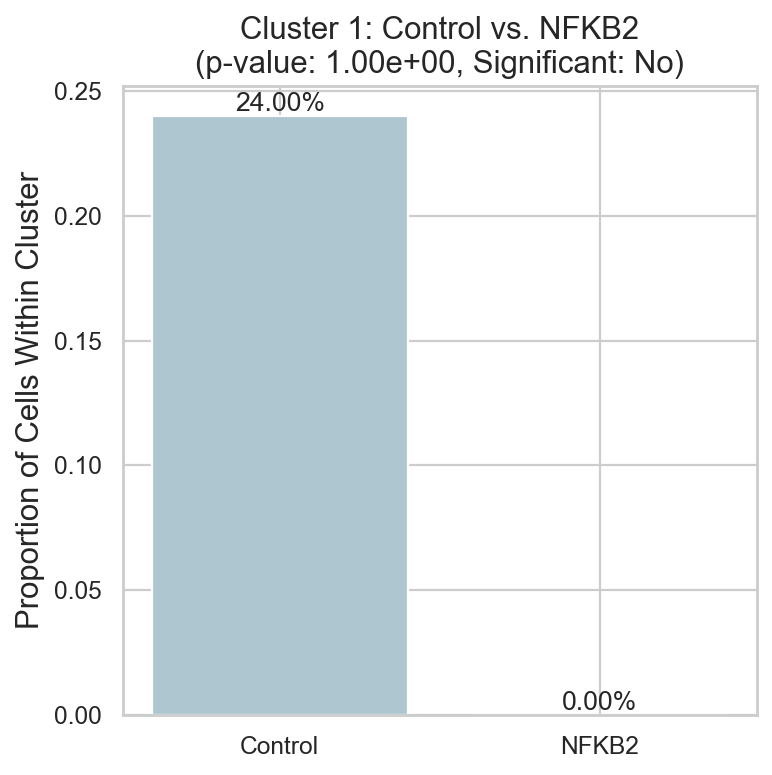

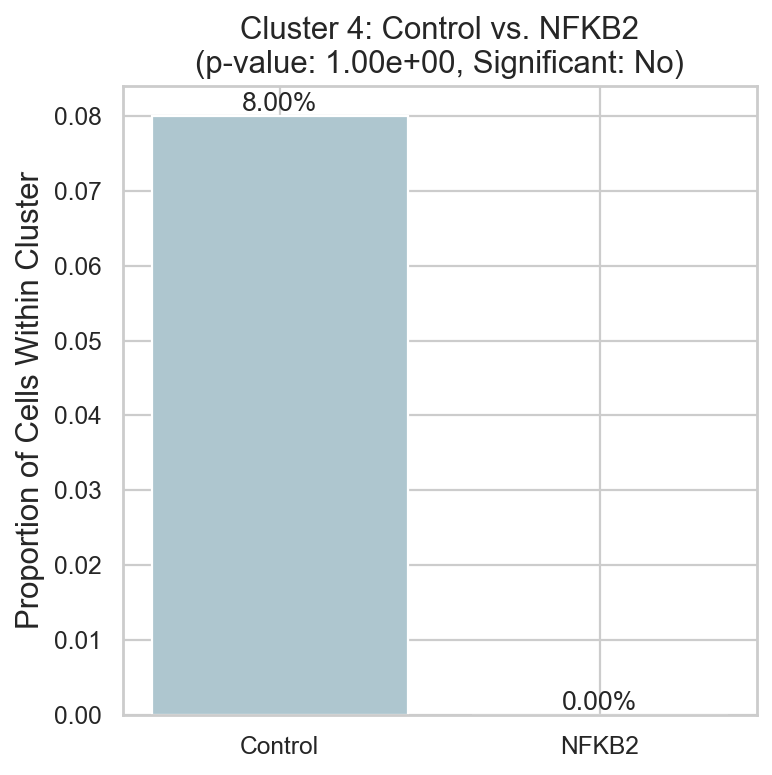

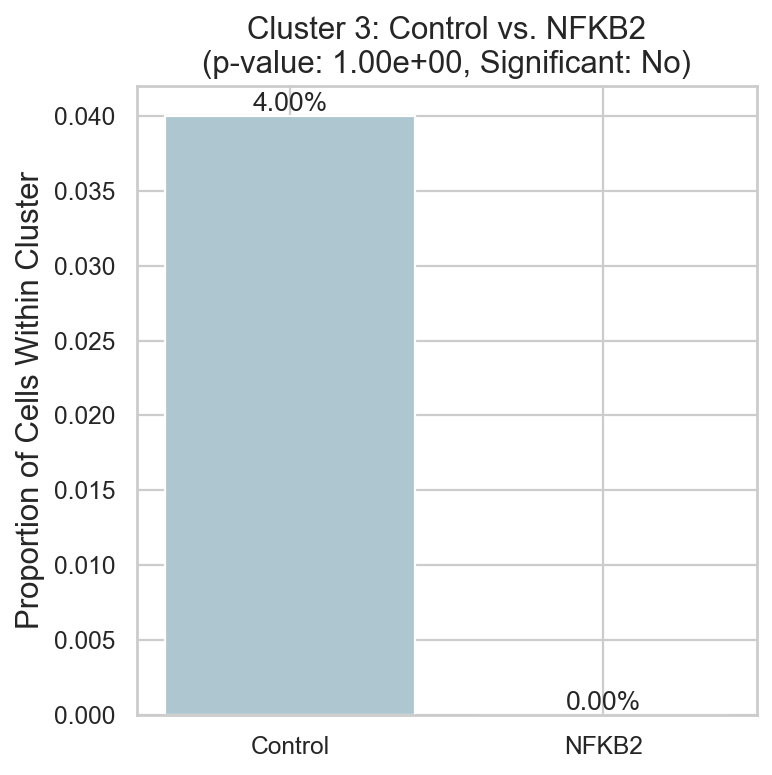

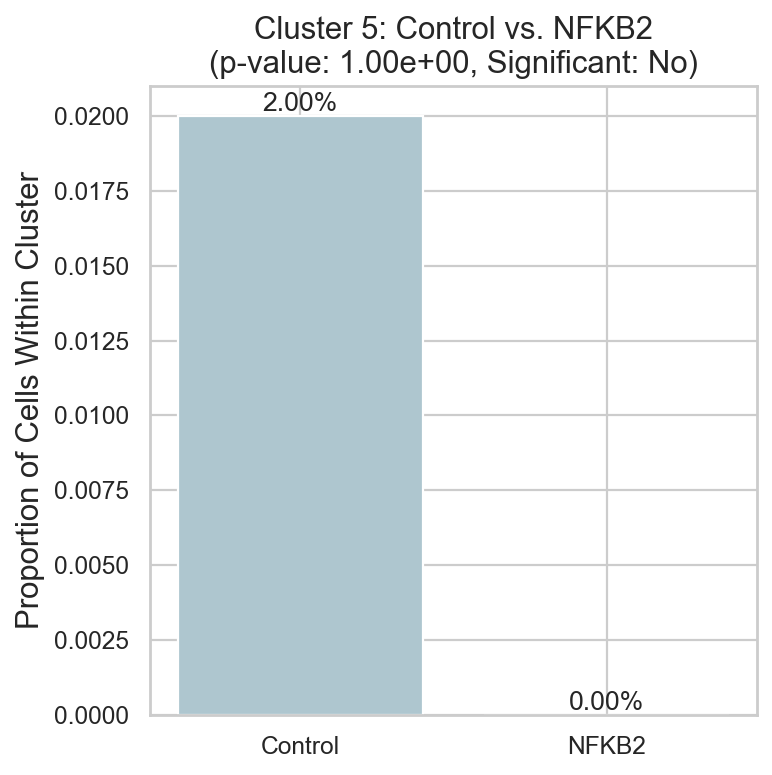

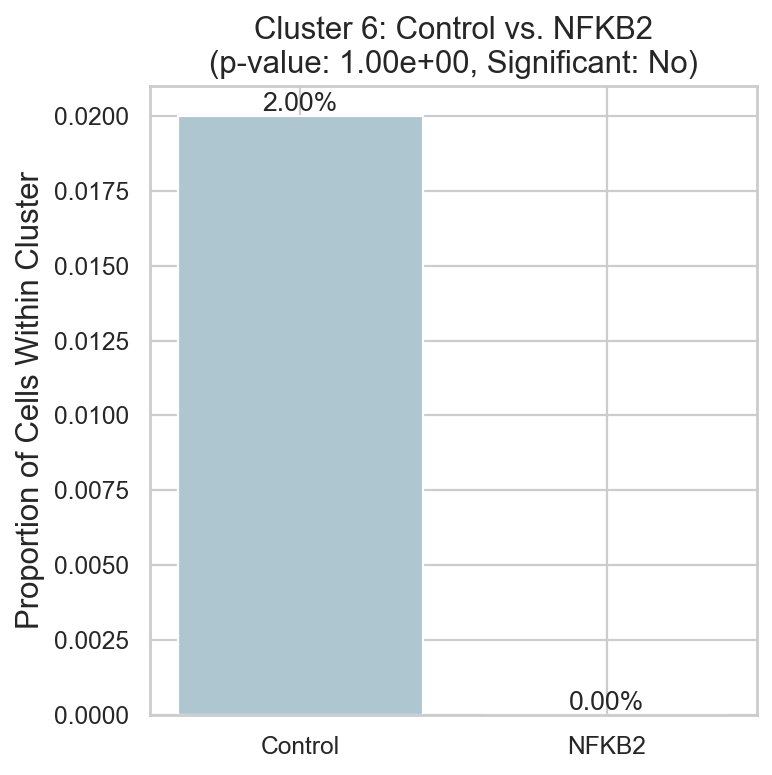

In [20]:
# Set a significance threshold
significance_threshold = 0.05

# Unique genes excluding 'control'
unique_genes = adata.obs['Gene'].unique()
unique_genes = unique_genes[unique_genes != 'control']

# Iterate over each unique gene
for gene in unique_genes:
    # Iterate over each cluster
    for cluster in adata.obs['leiden'].unique():
        # Construct a contingency table
        contingency_table = pd.DataFrame(
            [
                # Cells with current gene in cluster vs. outside cluster
                [
                    ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] == cluster)).sum(),
                    ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] != cluster)).sum(),
                ],
                # Control cells in cluster vs. outside cluster
                [
                    ((adata.obs['Gene'] == 'control') & (adata.obs['leiden'] == cluster)).sum(),
                    ((adata.obs['Gene'] == 'control') & (adata.obs['leiden'] != cluster)).sum(),
                ],
            ],
            index=[f"{gene}", "Control"],
            columns=[f"In_Cluster_{cluster}", f"Outside_Cluster_{cluster}"]
        )

        # Adjust for zeros if necessary
        epsilon = 1e-10
        contingency_table += epsilon

        # Perform chi-squared test
        chi2, p, _, _ = chi2_contingency(contingency_table)
        is_significant = p < significance_threshold
        # Cells for the gene of interest within and outside the cluster
        gene_in_cluster = ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] == cluster)).sum()
        gene_total = (adata.obs['Gene'] == gene).sum()
        prop_gene_in_cluster = gene_in_cluster / gene_total

        # Cells for the control within and outside the cluster
        control_in_cluster = ((adata.obs['Gene'] == 'control') & (adata.obs['leiden'] == cluster)).sum()
        control_total = (adata.obs['Gene'] == 'control').sum()
        prop_control_in_cluster = control_in_cluster / control_total

        # Plotting
        categories = ['Control', gene]
        proportions = [prop_control_in_cluster, prop_gene_in_cluster]
        plt.figure(figsize=(5, 5))
        bars = plt.bar(categories, proportions, color=['#aec6cf', '#ffb6c1'])

        plt.ylabel('Proportion of Cells Within Cluster', fontsize=14)
        plt.title(f'Cluster {cluster}: Control vs. {gene}\n(p-value: {p:.2e}, Significant: {"Yes" if is_significant else "No"})', fontsize=14)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2%}', ha='center', va='bottom', fontsize=12)

        plt.tight_layout()
        plt.show()


running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


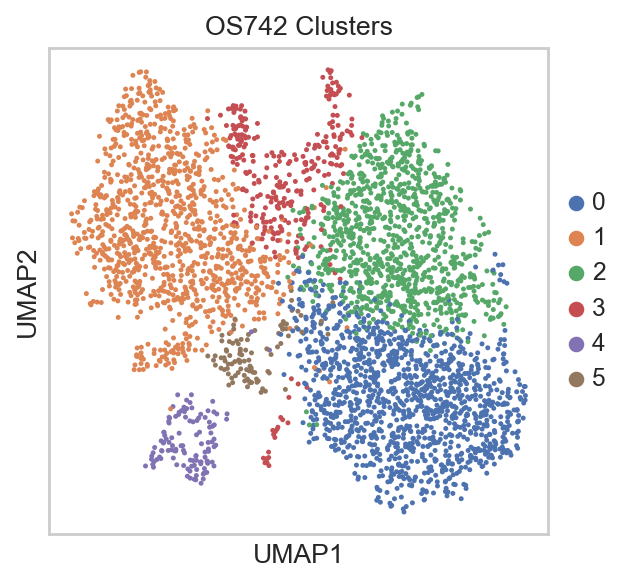

In [42]:
sc.tl.leiden(adata, resolution = 0.4)

sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS384 perturbseq - control cells",
    size = 20
)

In [28]:
# Saving the indices for filtering on wynton
modified_index = adata.obs.index.to_series().str.replace('-1', '')

# Save the modified index to a text file
modified_index.to_csv('OS384_cell_barcodes.txt', index=False, header=False)

# Adding the guide information

In [3]:
# This part of the analysis should be done on wynton
import h5py
molecule_info_path = 'molecule_info.h5'


# Function to print all datasets in an HDF5 file
def print_datasets(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(name)
        
        
# Open the HDF5 file and list datasets
with h5py.File(molecule_info_path, 'r') as f:
    f.visititems(print_datasets)
    
        
with h5py.File(molecule_info_path, 'r') as f:
    # Extract gRNA information. Adjust the keys as necessary based on your Cell Ranger version
    feature_ids = f['features/id'][:]
    feature_types = f['features/feature_type'][:]
    cell_barcodes = f['barcodes'][:]
    umi_counts = f['umi'][:]
    barcode_idx = f['barcode_idx'][:]
    feature_idx = f['feature_idx'][:]
    sequence = f['features/sequence'][:]


cell_barcodes = pd.DataFrame({
        'cell_barcodes': cell_barcodes
    })

In [9]:

# Resetting the index and renaming the index column
cell_barcodes = cell_barcodes.reset_index()
cell_barcodes = cell_barcodes.rename(columns={'index': 'barcode_idx'})



In [10]:

feature_id_sequences = pd.DataFrame({
    'sequence': sequence,
    'feature_ids': feature_ids
})


# Resetting the index and renaming the index column
feature_id_sequences = feature_id_sequences.reset_index()
feature_id_sequences = feature_id_sequences.rename(columns={'index': 'feature_idx'})

feature_id_sequences = feature_id_sequences[feature_id_sequences['sequence'] != b'']

In [14]:
barcode_data = pd.DataFrame({
    'barcode_idx': barcode_idx,
    'feature_idx': feature_idx,
    'umi_counts': umi_counts
})

In [16]:
# Merge the dataframes
merged_data = barcode_data.merge(feature_id_sequences, on='feature_idx', how='left')




In [ ]:
merged_data = merged_data.merge(cell_barcodes, on='barcode_idx', how='left')



In [ ]:
filtered_data = merged_data.dropna()

filtered_data.to_csv('OS384_molecular_data.csv', index=False)

# Reading in the mol_info data from wynton

In [7]:


# Reading in the macthed cell barcodes and guides that were generated in wynton
molecular_data = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_molecular_data.csv', index_col=0) 



# Keep only the 'feature_ids' and 'cell_barcodes' columns
molecular_data = molecular_data[['feature_ids', 'cell_barcodes']]

In [8]:
# Example: Stripping specific character (e.g., quote "'")
molecular_data['feature_ids'] = molecular_data['feature_ids'].str.strip("b'-2i'")
molecular_data['feature_ids'] = molecular_data['feature_ids'].str.strip("-1i")
molecular_data['cell_barcodes'] = molecular_data['cell_barcodes'].str.strip("b''")
# Remove duplicate rows across the entire DataFrame
molecular_data_unique = molecular_data.drop_duplicates()

In [9]:
molecular_data_unique

feature_ids     cell_barcodes
barcode_idx                              
35               NFE2L3  AAACCCAAGAATCGTA
35                 NFKB  AAACCCAAGAATCGTA
53               NFE2L3  AAACCCAAGACCACGA
61                 TSHZ  AAACCCAAGACCCTCA
73                  IRF  AAACCCAAGACGACGT
...                 ...               ...
3134211            STAT  TTTGTTGTCGTGCTCT
3134312             IRF  TTTGTTGTCTCGAACA
3134312            STAT  TTTGTTGTCTCGAACA
3134312            TSHZ  TTTGTTGTCTCGAACA
3134433             JUN  TTTGTTGTCTTGATTC

[165113 rows x 2 columns]

In [10]:
molecular_data_unique['cell_barcodes'] = molecular_data_unique['cell_barcodes'].apply(lambda x: f"{x}-1")


In [11]:
molecular_data_unique = molecular_data_unique.set_index('cell_barcodes')

In [12]:
adata.obs = adata.obs.assign(cell_barcode=adata.obs.index)


In [13]:
adata.obs['Gene'] = "control"

In [16]:
adata.obs

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGCATTTCG-1               9349       57095.0           2748.0   
AAACCCAAGGTCGTGA-1              10853      112640.0           3906.0   
AAACCCAAGTCACTCA-1               8370       61727.0           1725.0   
AAACCCACATGTAACC-1               8903       64270.0           1895.0   
AAACCCAGTACGCTTA-1               9422       65601.0           1717.0   
...                               ...           ...              ...   
TTTGGAGTCTTGATTC-1               8416       46731.0           1342.0   
TTTGGTTCAAATAAGC-1               7937       42909.0           1606.0   
TTTGGTTCACCGTCGA-1               8985       56413.0           1643.0   
TTTGGTTTCGGTCTAA-1               8325       47437.0           1246.0   
TTTGTTGAGTGACACG-1               7916       46602.0           1680.0   

                    pct_counts_mt  n_counts  initial_size   S_score  \
AAACCCAAGCATTTCG-1       4.813031   57095.0       57095.0 -0.036789   
AAACCCAAGGTCGTGA-1       3.467685  112640.0      112640.0 -0.469615   
AAACCCAAGTCACTCA-1       2.794563   61727.0       61727.0 -0.340296   
AAACCCACATGTAACC-1       2.948498   64270.0       64270.0  0.026636   
AAACCCAGTACGCTTA-1       2.617338   65601.0       65601.0  0.424476   
...                           ...       ...           ...       ...   
TTTGGAGTCTTGATTC-1       2.871755   46731.0       46731.0  0.130824   
TTTGGTTCAAATAAGC-1       3.742804   42909.0       42909.0 -0.111028   
TTTGGTTCACCGTCGA-1       2.912449   56413.0       56413.0 -0.054084   
TTTGGTTTCGGTCTAA-1       2.626642   47437.0       47437.0 -0.140259   
TTTGTTGAGTGACACG-1       3.604995   46602.0       46602.0 -0.692786   

                    G2M_score phase  ccdifference leiden        cell_barcode  \
AAACCCAAGCATTTCG-1   0.983448   G2M     -1.020237      0  AAACCCAAGCATTTCG-1   
AAACCCAAGGTCGTGA-1   0.262668   G2M     -0.732283      1  AAACCCAAGGTCGTGA-1   
AAACCCAAGTCACTCA-1  -0.453622    G1      0.113326      1  AAACCCAAGTCACTCA-1   
AAACCCACATGTAACC-1   0.968272   G2M     -0.941636      1  AAACCCACATGTAACC-1   
AAACCCAGTACGCTTA-1  -0.449721     S      0.874198      0  AAACCCAGTACGCTTA-1   
...                       ...   ...           ...    ...                 ...   
TTTGGAGTCTTGATTC-1  -0.768306     S      0.899130      1  TTTGGAGTCTTGATTC-1   
TTTGGTTCAAATAAGC-1   0.153038   G2M     -0.264067      2  TTTGGTTCAAATAAGC-1   
TTTGGTTCACCGTCGA-1   0.457294   G2M     -0.511378      2  TTTGGTTCACCGTCGA-1   
TTTGGTTTCGGTCTAA-1  -0.262978    G1      0.122719      1  TTTGGTTTCGGTCTAA-1   
TTTGTTGAGTGACACG-1  -0.887649    G1      0.194862      1  TTTGTTGAGTGACACG-1   

                                                                 Gene  
AAACCCAAGCATTTCG-1                                               TSHZ  
AAACCCAAGGTCGTGA-1                      IRF, NFE2L3, NFKB, NR0B, TCF4  
AAACCCAAGTCACTCA-1           IRF, JUN, NFE2L3, NFKB, STAT, TCF4, TSHZ  
AAACCCACATGTAACC-1     IRF, JUN, NFE2L3, NFKB, NR0B, STAT, TCF4, TSHZ  
AAACCCAGTACGCTTA-1           IRF, JUN, NFE2L3, NFKB, NR0B, STAT, TSHZ  
...                                                               ...  
TTTGGAGTCTTGATTC-1                 IRF, JUN, NFE2L3, NFKB, TCF4, TSHZ  
TTTGGTTCAAATAAGC-1                 IRF, JUN, NFE2L3, NFKB, NR0B, STAT  
TTTGGTTCACCGTCGA-1  IRF, JUN, NFE2L3, NFKB2, NFKB, NR0B, STAT, TCF...  
TTTGGTTTCGGTCTAA-1                 IRF, JUN, NFE2L3, NR0B, TCF4, TSHZ  
TTTGTTGAGTGACACG-1           IRF, JUN, NFE2L3, NFKB, NR0B, TCF4, TSHZ  

[3816 rows x 13 columns]

In [15]:
for barcode in molecular_data_unique.index:
    if barcode in adata.obs.index:
        # If barcode exists in AnnData, add/update gene info in .obs
        # Example: Add a concatenated string of genes to a new column, handling duplicates
        genes = molecular_data_unique.loc[barcode, 'feature_ids']
        gene_str = ', '.join(genes) if isinstance(genes, pd.Series) else genes
        adata.obs.at[barcode, 'Gene'] = gene_str
    else:
        # If barcode does not exist, add a new entry (optional, depends on your analysis needs)
        # You might need to handle adding new cells to `.X` or other attributes depending on your data structure
        genes = 'control'

In [17]:
# Filter observations where 'Gene' column does not contain a comma
adata = adata[~adata.obs['Gene'].str.contains(',')].copy()


In [18]:
adata.obs

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGCATTTCG-1               9349       57095.0           2748.0   
AAAGGTAAGTGGCAGT-1               9858       74027.0           2309.0   
AACCTTTAGACGAGCT-1               9231       71665.0           3084.0   
AACCTTTAGTGTTGTC-1               9195       56065.0           2235.0   
AACCTTTCAGATGCGA-1               8118       43854.0           2265.0   
...                               ...           ...              ...   
TTCTTCCTCCACGGAC-1               9579       79086.0           5115.0   
TTGATGGTCTGTCAGA-1               7580       43272.0           2066.0   
TTGCGTCTCACGGTCG-1               8637       50283.0           2251.0   
TTGGTTTTCGCTTTAT-1              11615      107967.0           3769.0   
TTGTTTGCACTACGGC-1              10262       76772.0           1282.0   

                    pct_counts_mt  n_counts  initial_size   S_score  \
AAACCCAAGCATTTCG-1       4.813031   57095.0       57095.0 -0.036789   
AAAGGTAAGTGGCAGT-1       3.119132   74027.0       74027.0  0.517927   
AACCTTTAGACGAGCT-1       4.303356   71665.0       71665.0 -0.763863   
AACCTTTAGTGTTGTC-1       3.986444   56065.0       56065.0  0.908318   
AACCTTTCAGATGCGA-1       5.164865   43854.0       43854.0  0.268238   
...                           ...       ...           ...       ...   
TTCTTCCTCCACGGAC-1       6.467643   79086.0       79086.0 -0.362962   
TTGATGGTCTGTCAGA-1       4.774450   43272.0       43272.0 -0.578858   
TTGCGTCTCACGGTCG-1       4.476662   50283.0       50283.0 -0.219486   
TTGGTTTTCGCTTTAT-1       3.490882  107967.0      107967.0  0.673193   
TTGTTTGCACTACGGC-1       1.669880   76772.0       76772.0 -1.448646   

                    G2M_score phase  ccdifference leiden        cell_barcode  \
AAACCCAAGCATTTCG-1   0.983448   G2M     -1.020237      0  AAACCCAAGCATTTCG-1   
AAAGGTAAGTGGCAGT-1   0.693743   G2M     -0.175815      0  AAAGGTAAGTGGCAGT-1   
AACCTTTAGACGAGCT-1  -1.185112    G1      0.421249      2  AACCTTTAGACGAGCT-1   
AACCTTTAGTGTTGTC-1   0.517486     S      0.390832      0  AACCTTTAGTGTTGTC-1   
AACCTTTCAGATGCGA-1   0.642687   G2M     -0.374449      0  AACCTTTCAGATGCGA-1   
...                       ...   ...           ...    ...                 ...   
TTCTTCCTCCACGGAC-1  -0.704115    G1      0.341153      1  TTCTTCCTCCACGGAC-1   
TTGATGGTCTGTCAGA-1  -0.711468    G1      0.132610      1  TTGATGGTCTGTCAGA-1   
TTGCGTCTCACGGTCG-1  -0.610756    G1      0.391270      1  TTGCGTCTCACGGTCG-1   
TTGGTTTTCGCTTTAT-1  -0.715959     S      1.389151      1  TTGGTTTTCGCTTTAT-1   
TTGTTTGCACTACGGC-1  -1.281873    G1     -0.166772      2  TTGTTTGCACTACGGC-1   

                      Gene  
AAACCCAAGCATTTCG-1    TSHZ  
AAAGGTAAGTGGCAGT-1  NFE2L3  
AACCTTTAGACGAGCT-1  NFE2L3  
AACCTTTAGTGTTGTC-1     IRF  
AACCTTTCAGATGCGA-1     IRF  
...                    ...  
TTCTTCCTCCACGGAC-1    TCF4  
TTGATGGTCTGTCAGA-1     IRF  
TTGCGTCTCACGGTCG-1  NFE2L3  
TTGGTTTTCGCTTTAT-1  NFE2L3  
TTGTTTGCACTACGGC-1    TCF4  

[250 rows x 13 columns]

In [ ]:
# Convert 'feature_ids' column to string
merged_data['feature_ids'] = merged_data['feature_ids'].astype(str)

In [ ]:
# Filter rows where 'feature_ids' column contains the string "LT"
filtered_data = merged_data[merged_data['feature_ids'].str.contains("LT", na=False)]


In [5]:






# Filter for gRNA features
is_barcode = feature_types == b'CRISPR Guide Capture'  # Adjust if your gRNA feature type is named differently
barcode_ids = feature_ids[is_barcode]

# Filter gRNA data
barcode_data = barcode_data[barcode_data['feature_idx'].isin(barcode_ids)]

# Aggregate UMIs per cell barcode for each gRNA
barcode_counts = barcode_data.groupby(['barcode_idx', 'feature_idx']).umi_counts.sum().unstack(fill_value=0)


# Map indices to actual barcode and gRNA IDs
barcode_counts.index = [cell_barcodes[i].decode('utf-8') for i in barcode_counts.index]
barcode_counts.columns = [barcode_ids[i].decode('utf-8') for i in barcode_counts.columns]


# Integrate gRNA counts into AnnData
for gRNA_id in gRNA_counts.columns:
    adata.obs[gRNA_id] = gRNA_counts[gRNA_id].reindex(adata.obs_names, fill_value=0)


IndentationError: expected an indented block (2121546841.py, line 12)

# Reading molecular_info data from cellranger output

In [19]:
mol_info = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_molecular_data.csv')


In [28]:
mol_info

feature_ids       cell_barcodes
0            NFE2L3  AAACCCAAGAATCGTA-1
1             NFKB2  AAACCCAAGAATCGTA-1
2            NFE2L3  AAACCCAAGACCACGA-1
3             TSHZ2  AAACCCAAGACCCTCA-1
4              IRF1  AAACCCAAGACGACGT-1
...             ...                 ...
3084788        IRF1  TTTGTTGTCTCGAACA-1
3084789       STAT1  TTTGTTGTCTCGAACA-1
3084790       STAT1  TTTGTTGTCTCGAACA-1
3084791       TSHZ2  TTTGTTGTCTCGAACA-1
3084792         JUN  TTTGTTGTCTTGATTC-1

[3084793 rows x 2 columns]

In [21]:
mol_info = mol_info.iloc[:, -2:]  # Selects the last two columns


In [23]:
def strip_b(string):
    if isinstance(string, str):
        return string.replace("b'", "").replace("'", "")
    return string

mol_info = mol_info.applymap(strip_b)


In [25]:
def strip_b(string):
    if isinstance(string, str):
        return string.replace("-2i", "").replace("-1i", "")
    return string

mol_info = mol_info.applymap(strip_b)


In [27]:
mol_info['cell_barcodes'] = mol_info['cell_barcodes'].apply(lambda x: f"{x}-1")


In [29]:
mol_info = mol_info.set_index('cell_barcodes')


In [ ]:
for barcode in mol_info.index:
    if barcode in adata.obs.index:
        # If barcode exists in AnnData, add/update gene info in .obs
        # Example: Add a concatenated string of genes to a new column, handling duplicates
        genes = mol_info.loc[barcode, 'feature_ids']
        gene_str = ', '.join(genes) if isinstance(genes, pd.Series) else genes
        adata.obs.at[barcode, 'Gene'] = gene_str
    else:
        # If barcode does not exist, add a new entry (optional, depends on your analysis needs)
        # You might need to handle adding new cells to `.X` or other attributes depending on your data structure
        genes = 'control'

In [ ]:
adata.obs